<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Diabetes_Prediction_Challenge/Notebook/Diabetes_Prediction_Challenge_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#   # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [2]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# playground_series_s5e11_path = kagglehub.competition_download('playground-series-s5e11')
# nabihazahid_loan_prediction_dataset_2025_path = kagglehub.dataset_download('nabihazahid/loan-prediction-dataset-2025')

# print('Data source import complete.')


In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction  
This notebook provides a clear and simple workflow for the **“Predicting Loan Payback” — Kaggle Playground Series S5E11** competition.  
We will go through the full process: **loading the data, exploring it, preprocessing, training models, evaluating them, and creating a valid submission file**.

---

## What is Loan Payback Prediction?  
Loan payback prediction means identifying whether a borrower will **repay the loan** or **default**.  
This is a binary classification problem.

The result depends on factors such as:

- Borrower income, age, employment  
- Loan amount, interest rate  
- Credit history and past defaults  
- Other financial indicators  

---

## Competition Objective  
Your goal is to **predict the target column indicating loan payback** for each entry in the test set.

### ✔ Evaluation Metric  
The competition uses **AUC ROC**, which measures how well the model separates positive vs negative classes.

---

## About the Dataset  
- The dataset contains **synthetic loan records** created for practice.  
- It includes both **numerical** and **categorical** features.  
- The train, test, and sample submission files are located in your Drive:  


# 1. Setup & data loading

In [4]:


# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
N_SPLITS = 7
TARGET = 'diagnosed_diabetes'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# # 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
# train_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/train.csv'
# test_path = '/content/drive/MyDrive/Predicting Loan Payback/playground-series-s5e11/test.csv'

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np

# --- 1. Load datasets ---
print("Loading datasets...")
train_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/train.csv'
test_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/test.csv'
orig_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/OG/diabetes_dataset.csv'
sample_submission_path = '/content/drive/MyDrive/Kaggle/Diebieties prediction challange/sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_orig = pd.read_csv(orig_path)
df_sample_submission = pd.read_csv(sample_submission_path)
print("Datasets loaded successfully.")

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Shape of df_orig: {df_orig.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")

Loading datasets...
Datasets loaded successfully.

--- Dataset Shapes ---
Shape of df_train: (700000, 26)
Shape of df_test: (300000, 25)
Shape of df_orig: (100000, 31)
Shape of df_sample_submission: (300000, 2)


# 2. Exploratory data analysis

## 2.1 Data information

In [7]:
import numpy as np

#Facing session crashes due to low memory space
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

print("Applying memory reduction to df_train...")
df_train = reduce_mem_usage(df_train)
print("Applying memory reduction to df_test...")
df_test = reduce_mem_usage(df_test)
print("Applying memory reduction to df_orig...")
df_orig = reduce_mem_usage(df_orig)


Applying memory reduction to df_train...
Memory usage of dataframe is 138.86 MB
Memory usage after optimization is: 34.71 MB
Decreased by 75.0%
Applying memory reduction to df_test...
Memory usage of dataframe is 57.22 MB
Memory usage after optimization is: 13.73 MB
Decreased by 76.0%
Applying memory reduction to df_orig...
Memory usage of dataframe is 23.65 MB
Memory usage after optimization is: 5.91 MB
Decreased by 75.0%


In [8]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")


📊 Comprehensive Information for DataFrame: df_train

Shape: 700000 rows × 26 columns

--- df_train Head ---



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.700000,6.800000,6.100000,33.400002,0.930000,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.000000
1,1,50,2,73,5.700000,6.500000,5.800000,23.799999,0.830000,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.000000
2,2,32,3,158,8.500000,7.400000,9.100000,24.100000,0.830000,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.000000
3,3,54,3,77,4.600000,7.000000,9.200000,26.600000,0.830000,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.000000
4,4,54,1,55,5.700000,6.200000,5.100000,28.799999,0.900000,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.000000



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int32,700000,700000,0,0.000000
age,int8,700000,71,0,0.000000
alcohol_consumption_per_week,int8,700000,9,0,0.000000
physical_activity_minutes_per_week,int16,700000,565,0,0.000000
diet_score,float32,700000,99,0,0.000000
sleep_hours_per_day,float32,700000,69,0,0.000000
screen_time_hours_per_day,float32,700000,151,0,0.000000
bmi,float32,700000,231,0,0.000000
waist_to_hip_ratio,float32,700000,36,0,0.000000
systolic_bp,int16,700000,71,0,0.000000



--- df_train Numeric Summary ---



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,349999.500000,50.359734,2.072411,80.230803,5.963696,7.002201,6.012733,25.874683,0.858766,116.294193,75.440924,70.167749,186.818801,53.823214,102.905854,123.081850,0.149401,0.181990,0.030324,0.623296
std,202072.738554,11.655520,1.048189,51.195071,1.463622,0.901949,2.022674,2.861331,0.037966,11.010390,6.825775,6.938722,16.730832,8.266545,19.022416,24.739397,0.356484,0.385837,0.171478,0.484304
min,0.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.680000,91.000000,51.000000,42.000000,117.000000,21.000000,51.000000,31.000000,0.000000,0.000000,0.000000,0.000000
25%,174999.750000,42.000000,1.000000,49.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,175.000000,48.000000,89.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,349999.500000,50.000000,2.000000,71.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000,1.000000
75%,524999.250000,58.000000,3.000000,96.000000,7.000000,7.600000,7.400000,27.799999,0.880000,124.000000,80.000000,75.000000,199.000000,59.000000,116.000000,139.000000,0.000000,0.000000,0.000000,1.000000
max,699999.000000,89.000000,9.000000,747.000000,9.900000,9.900000,16.500000,38.400002,1.050000,163.000000,104.000000,101.000000,289.000000,90.000000,205.000000,290.000000,1.000000,1.000000,1.000000,1.000000



--- df_train Categorical Summary ---



,count,unique,top,freq
gender,700000,3,Female,363237
ethnicity,700000,5,White,386153
education_level,700000,4,Highschool,344145
income_level,700000,5,Middle,290557
smoking_status,700000,3,Never,494448
employment_status,700000,4,Employed,516170





📊 Comprehensive Information for DataFrame: df_test

Shape: 300000 rows × 25 columns

--- df_test Head ---



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.300000,6.800000,6.200000,25.500000,0.840000,123,70,64,209,55,135,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.500000,4.600000,9.000000,28.600000,0.880000,120,74,59,159,47,83,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.600000,6.800000,7.000000,28.500000,0.940000,112,71,75,173,43,99,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.300000,7.300000,5.000000,26.900000,0.910000,114,81,61,203,59,116,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.300000,7.600000,8.500000,22.000000,0.830000,131,78,79,177,59,87,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int32,300000,300000,0,0.000000
age,int8,300000,71,0,0.000000
alcohol_consumption_per_week,int8,300000,9,0,0.000000
physical_activity_minutes_per_week,int16,300000,544,0,0.000000
diet_score,float32,300000,99,0,0.000000
sleep_hours_per_day,float32,300000,68,0,0.000000
screen_time_hours_per_day,float32,300000,147,0,0.000000
bmi,float32,300000,230,0,0.000000
waist_to_hip_ratio,float32,300000,37,0,0.000000
systolic_bp,int16,300000,77,0,0.000000



--- df_test Numeric Summary ---



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,849999.500000,50.432397,2.089693,92.349087,5.945838,6.997795,6.011278,25.881905,0.859007,116.374117,75.396013,70.048350,187.308620,53.813557,103.416083,123.538480,0.152920,0.184410,0.033110
std,86602.684716,11.938741,1.066214,62.187399,1.481215,0.914836,2.060668,2.894137,0.038533,11.252146,6.950340,7.090543,18.413053,8.398126,20.571855,28.965441,0.359911,0.387819,0.178924
min,700000.000000,19.000000,1.000000,1.000000,0.100000,3.100000,0.600000,15.100000,0.690000,91.000000,51.000000,42.000000,107.000000,22.000000,51.000000,31.000000,0.000000,0.000000,0.000000
25%,774999.750000,42.000000,1.000000,51.000000,5.000000,6.400000,4.600000,23.900000,0.830000,108.000000,71.000000,65.000000,174.000000,48.000000,89.000000,104.000000,0.000000,0.000000,0.000000
50%,849999.500000,50.000000,2.000000,77.000000,6.000000,7.000000,6.000000,25.900000,0.860000,116.000000,75.000000,70.000000,187.000000,54.000000,103.000000,123.000000,0.000000,0.000000,0.000000
75%,924999.250000,59.000000,3.000000,115.000000,7.000000,7.600000,7.400000,27.799999,0.890000,124.000000,80.000000,75.000000,200.000000,60.000000,117.000000,142.000000,0.000000,0.000000,0.000000
max,999999.000000,89.000000,9.000000,748.000000,9.900000,9.900000,15.900000,38.299999,1.050000,170.000000,104.000000,101.000000,285.000000,91.000000,226.000000,290.000000,1.000000,1.000000,1.000000



--- df_test Categorical Summary ---



,count,unique,top,freq
gender,300000,3,Female,154098
ethnicity,300000,5,White,168375
education_level,300000,4,Highschool,153355
income_level,300000,5,Middle,124249
smoking_status,300000,3,Never,211666
employment_status,300000,4,Employed,217993


## 2.2 Numerical/Categorical Feature Identification

In [9]:
# Define excluded features: 'id' and the target variable 'loan_paid_back'
excluded_features = ['id', 'diagnosed_diabetes']

print("\n--- Feature Classification Based on df_train ---")

# Separate numerical features from df_train, excluding the specified features
numerical_features = [
    col for col in df_train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

# Separate categorical features from df_train, excluding the specified features
categorical_features = [
    col for col in df_train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]


print("Numerical Features:")
print(f"  Total Count: {len(numerical_features)}")
print(f"  List: {numerical_features}\n")

print("Categorical Features:")
print(f"  Total Count: {len(categorical_features)}")
print(f"  List: {categorical_features}\n")

print("Excluded Features (ID and Target Variable):")
print(f"  List: {excluded_features}\n")


--- Feature Classification Based on df_train ---
Numerical Features:
  Total Count: 18
  List: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']

Categorical Features:
  Total Count: 6
  List: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']

Excluded Features (ID and Target Variable):
  List: ['id', 'diagnosed_diabetes']



## 2.3 Correlation Heatmap

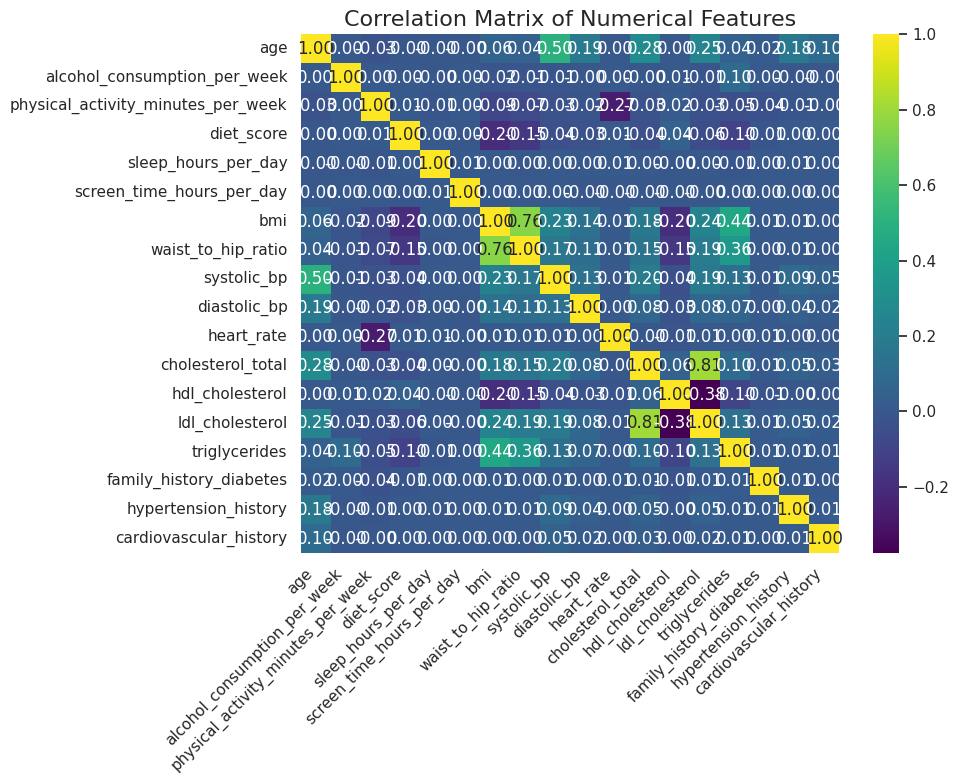

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 2.4 Numerical Feature Distributions (Train vs Test)


📌 age Summary Statistics:


,Train,Test
Mean,50.359734,50.432397
Median,50.000000,50.000000
Std,11.655520,11.938741


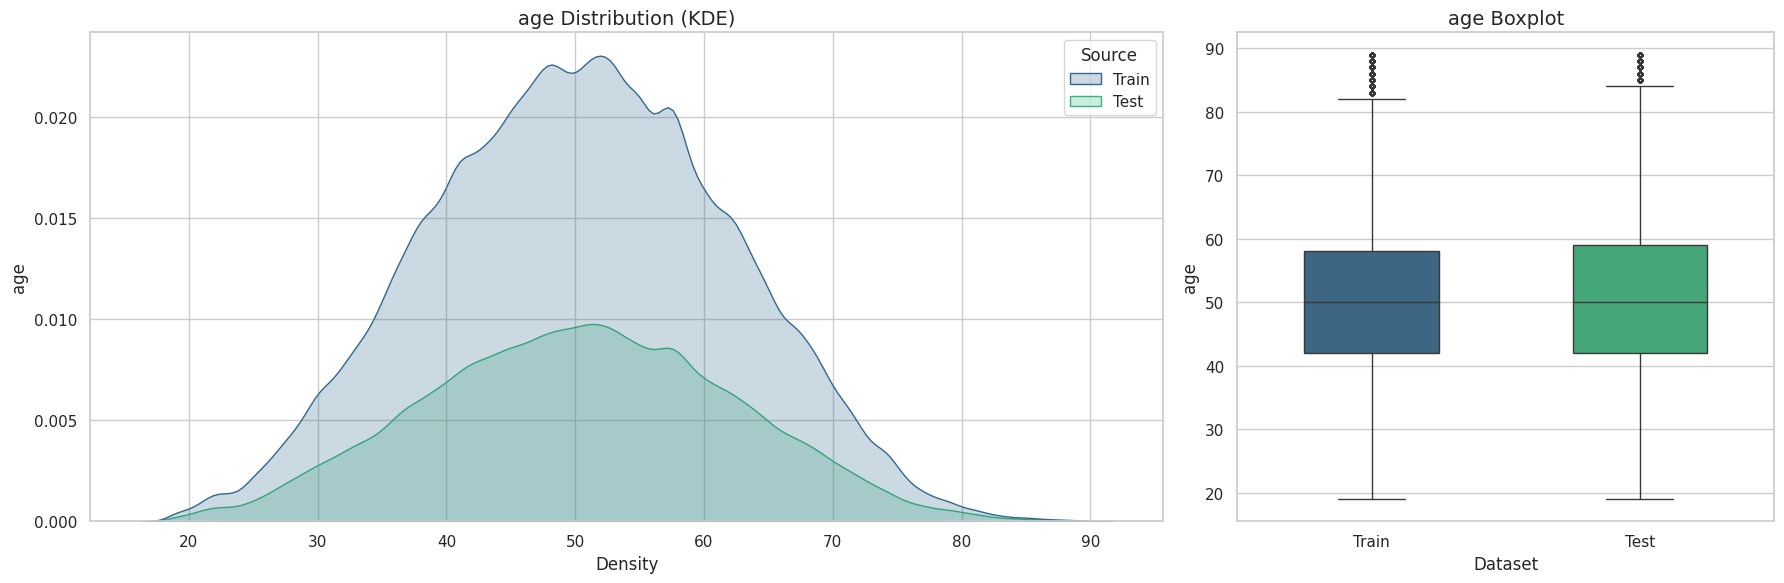


📌 alcohol_consumption_per_week Summary Statistics:


,Train,Test
Mean,2.072411,2.089693
Median,2.000000,2.000000
Std,1.048189,1.066214


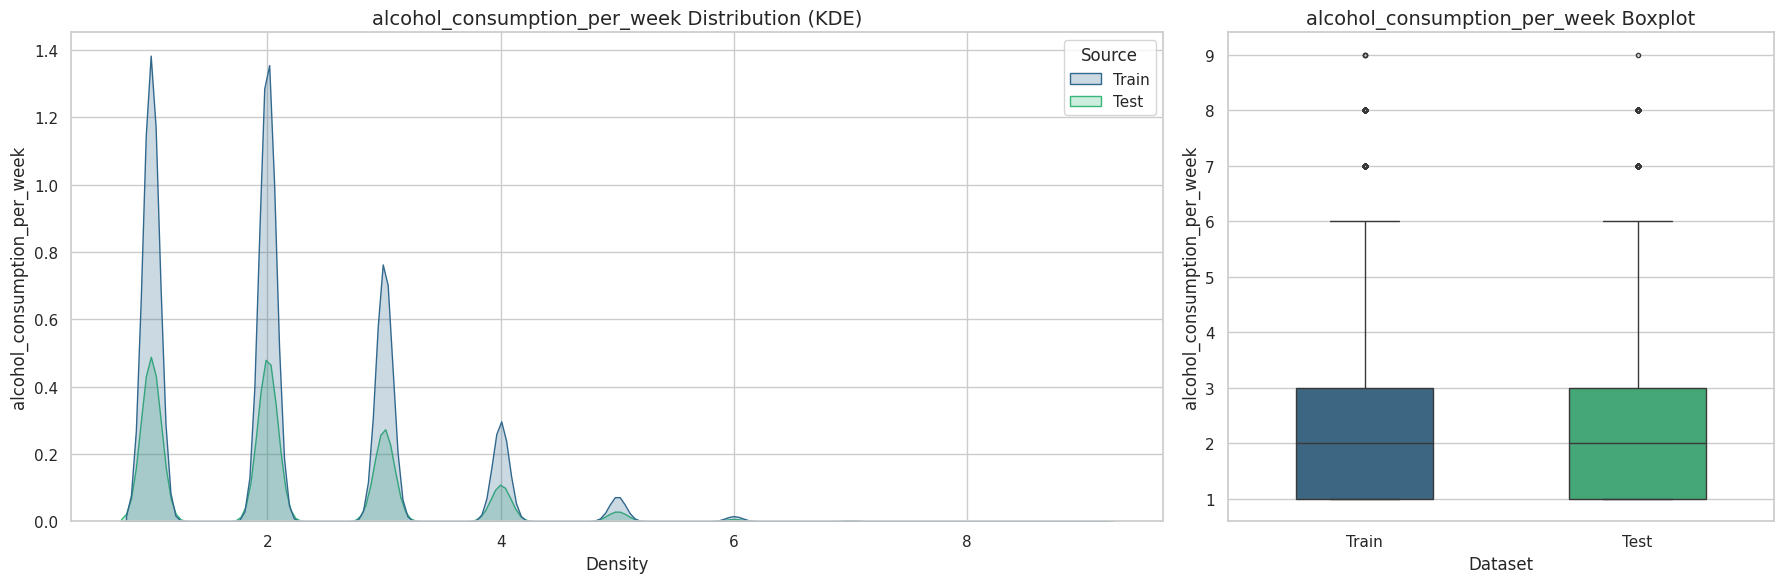


📌 physical_activity_minutes_per_week Summary Statistics:


,Train,Test
Mean,80.230803,92.349087
Median,71.000000,77.000000
Std,51.195071,62.187399


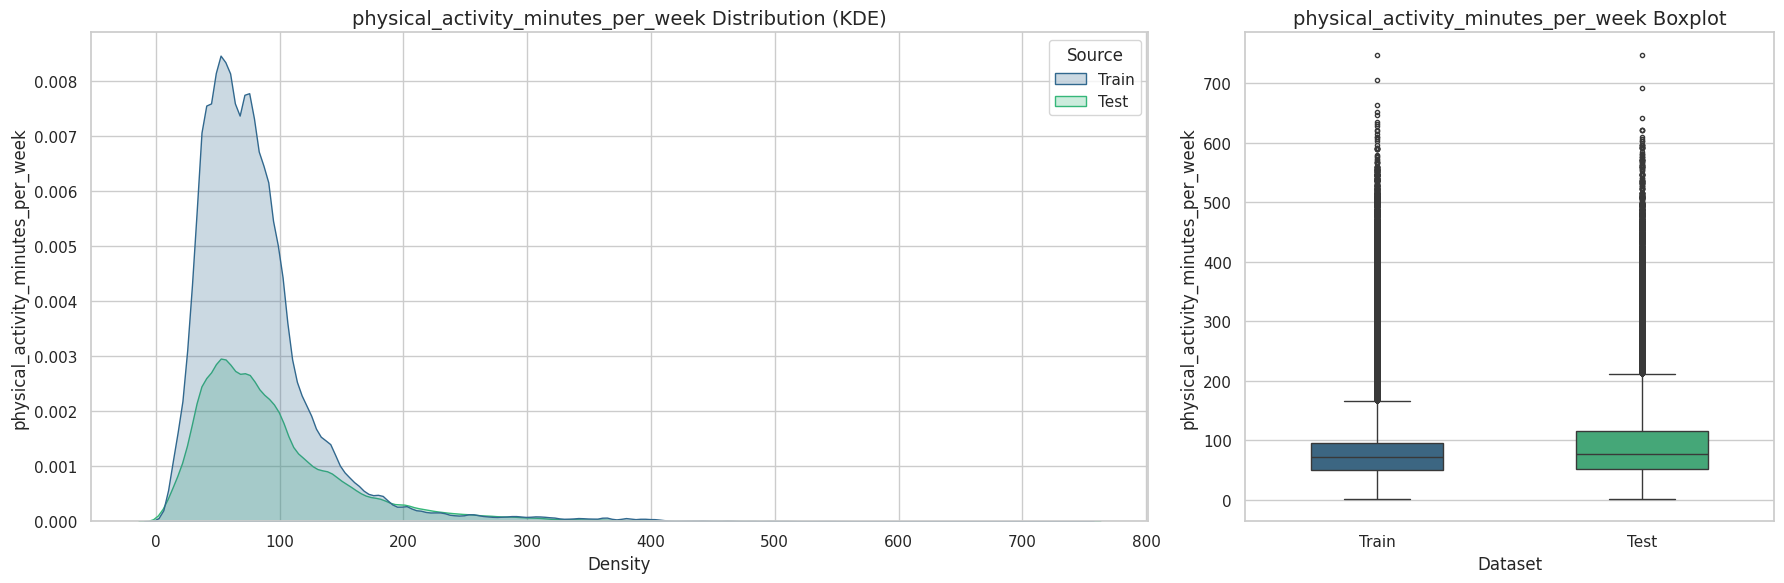


📌 diet_score Summary Statistics:


,Train,Test
Mean,5.963696,5.945838
Median,6.000000,6.000000
Std,1.463622,1.481215


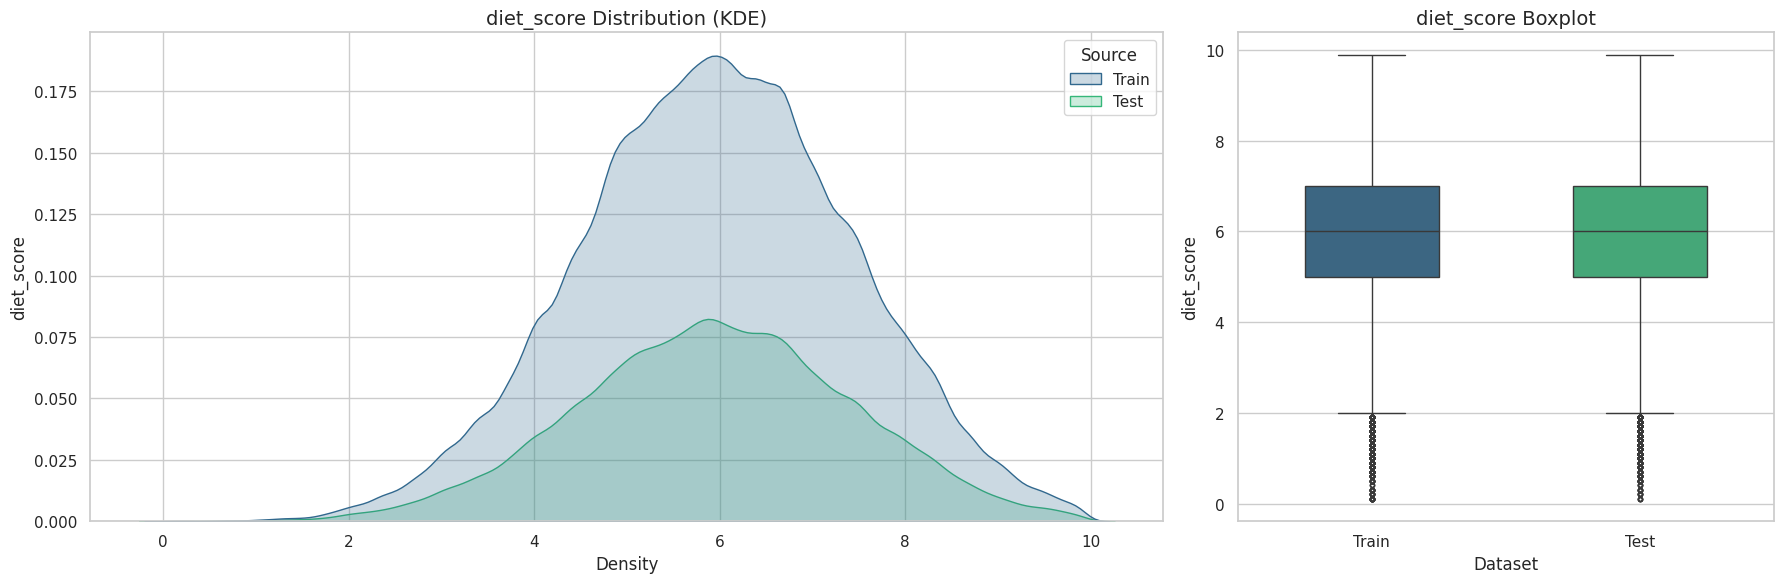


📌 sleep_hours_per_day Summary Statistics:


,Train,Test
Mean,7.002201,6.997795
Median,7.000000,7.000000
Std,0.901949,0.914836


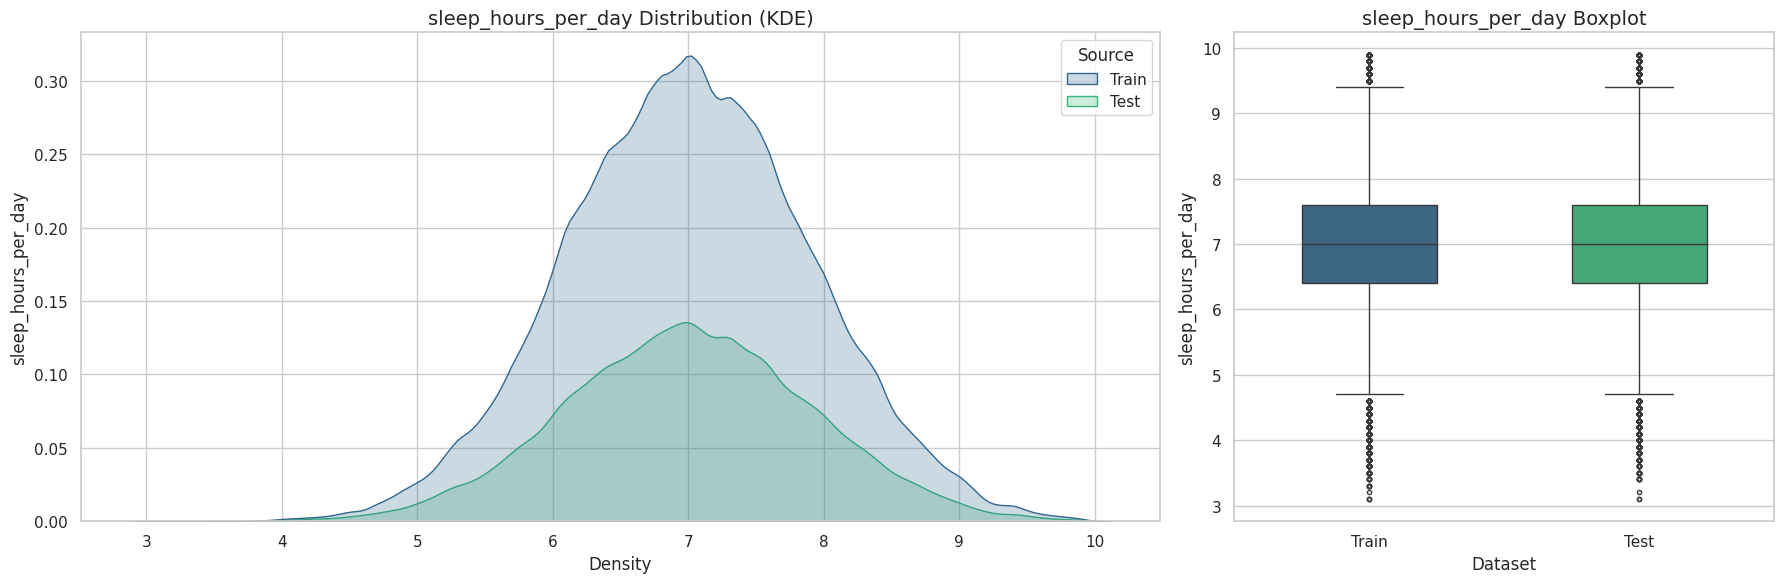


📌 screen_time_hours_per_day Summary Statistics:


,Train,Test
Mean,6.012733,6.011278
Median,6.000000,6.000000
Std,2.022674,2.060668


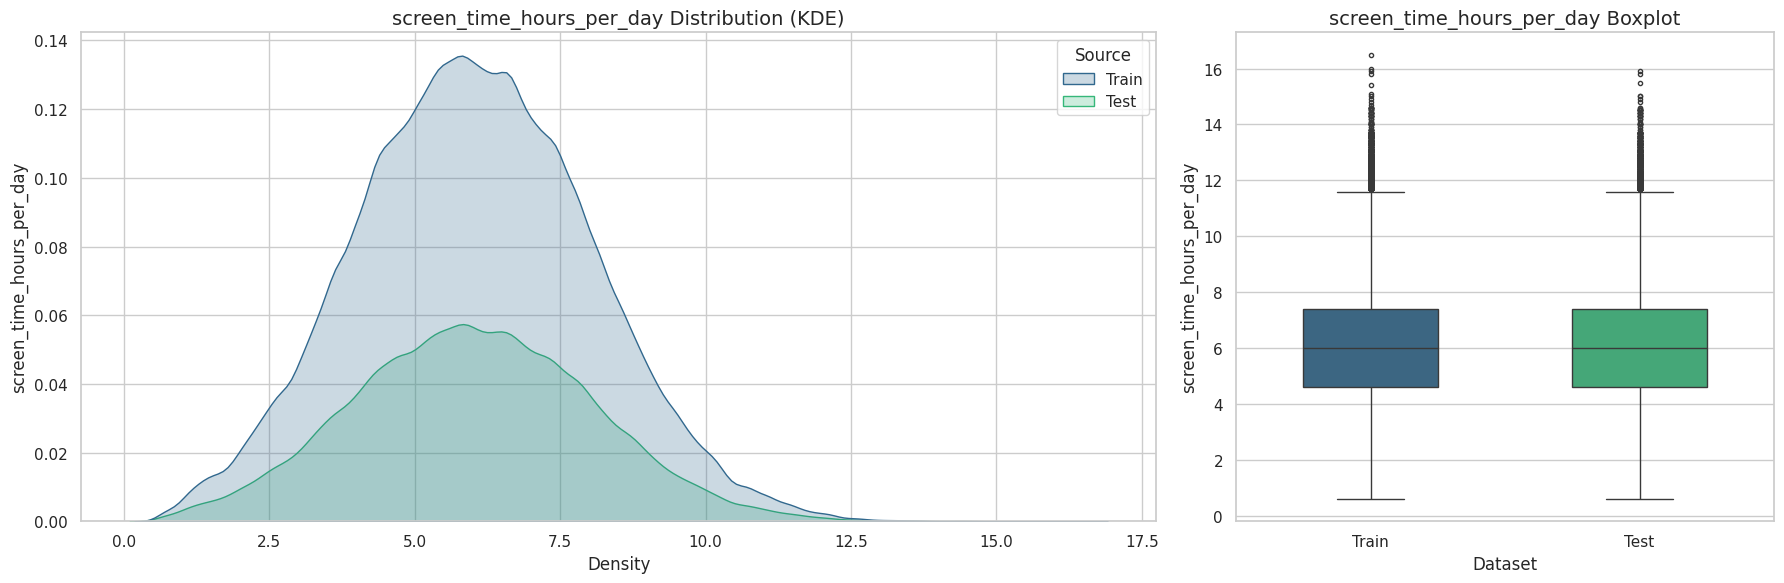


📌 bmi Summary Statistics:


,Train,Test
Mean,25.874683,25.881905
Median,25.900000,25.900000
Std,2.861331,2.894137


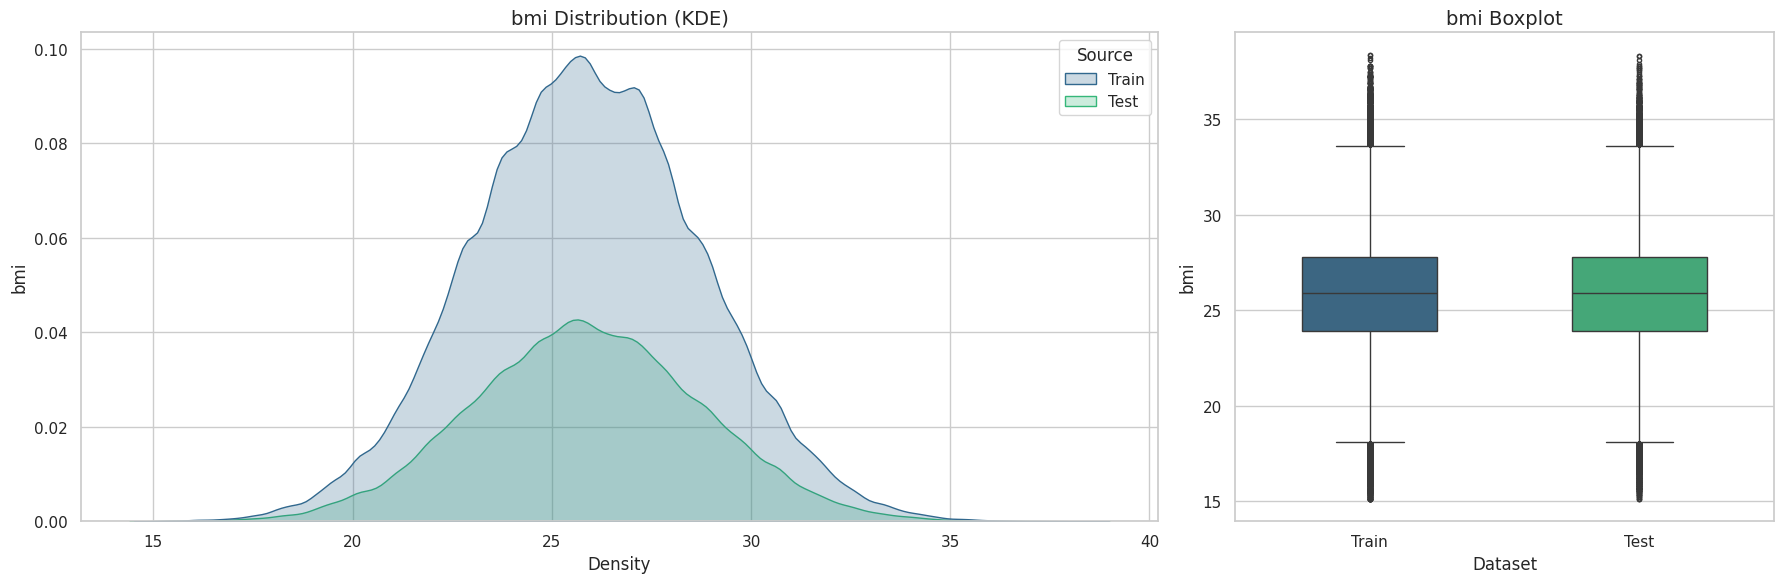


📌 waist_to_hip_ratio Summary Statistics:


,Train,Test
Mean,0.858766,0.859007
Median,0.860000,0.860000
Std,0.037966,0.038533


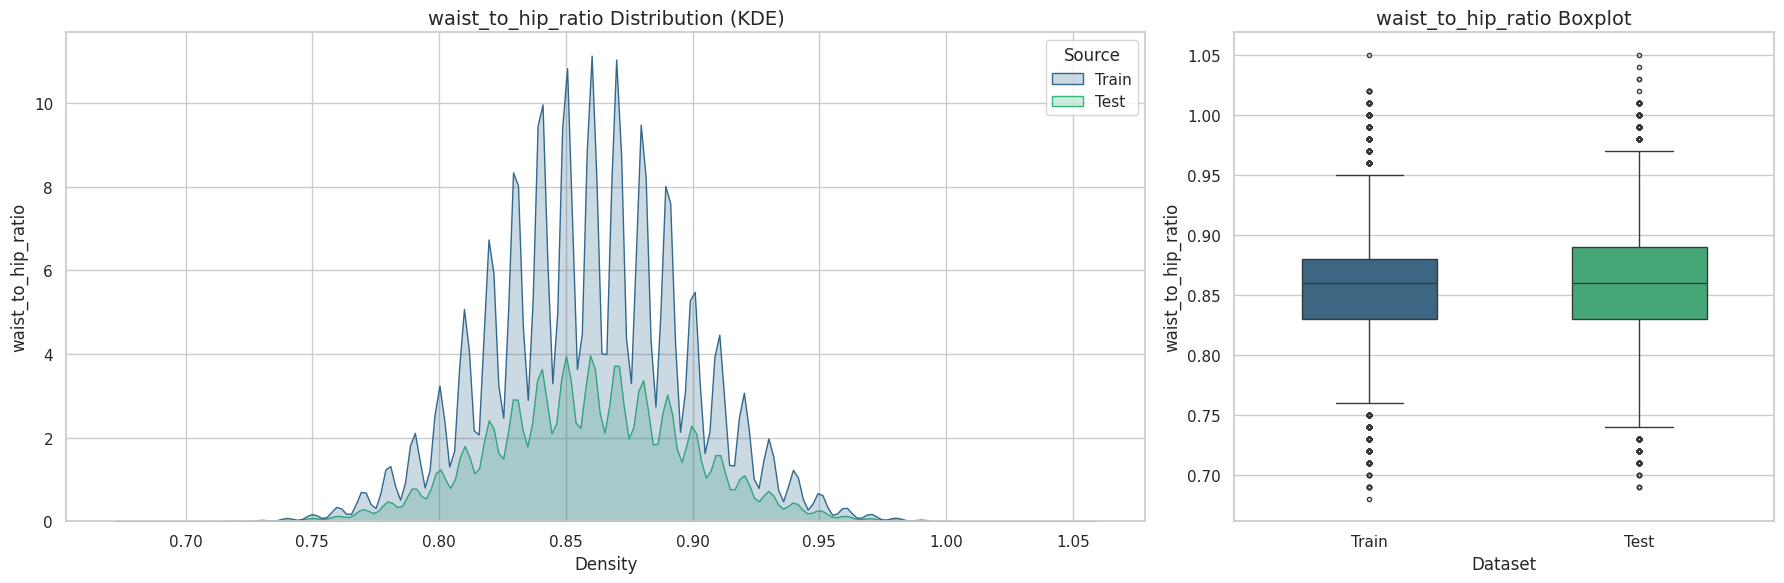


📌 systolic_bp Summary Statistics:


,Train,Test
Mean,116.294193,116.374117
Median,116.000000,116.000000
Std,11.010390,11.252146


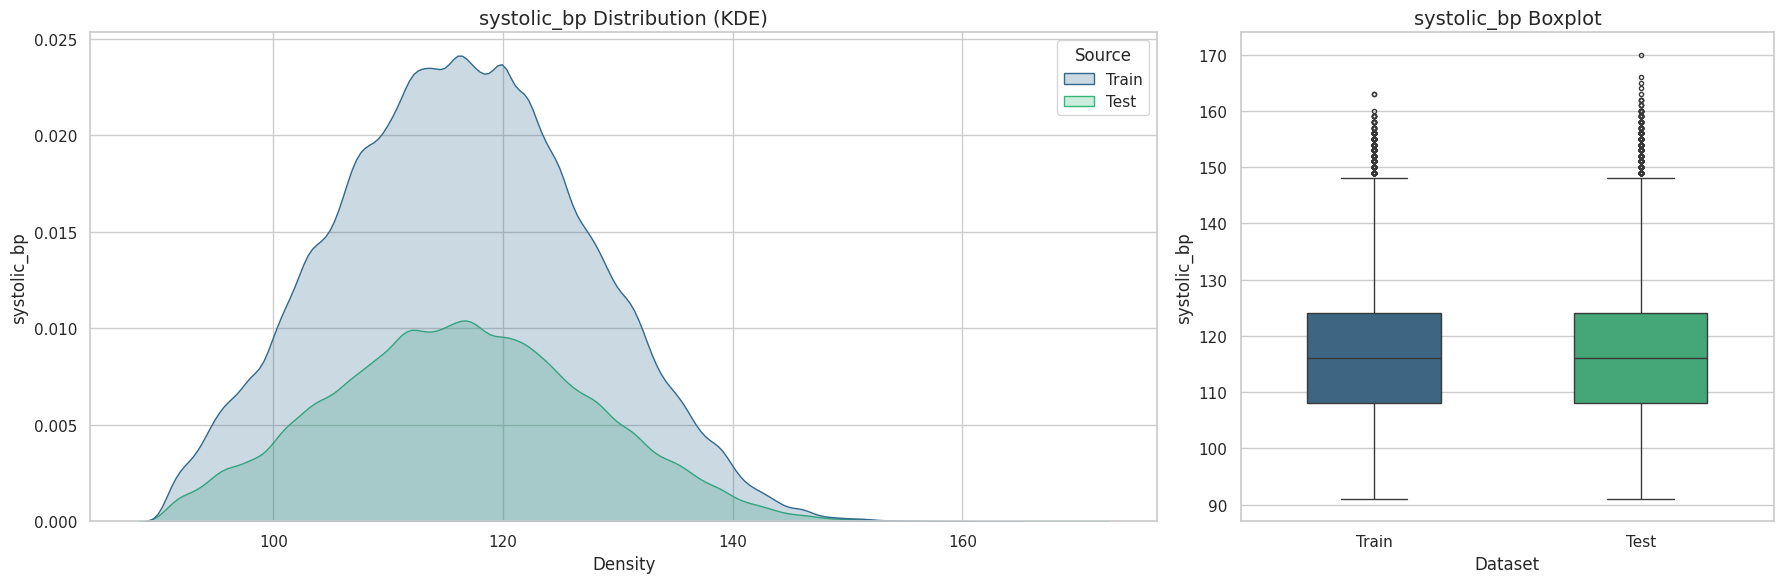


📌 diastolic_bp Summary Statistics:


,Train,Test
Mean,75.440924,75.396013
Median,75.000000,75.000000
Std,6.825775,6.950340


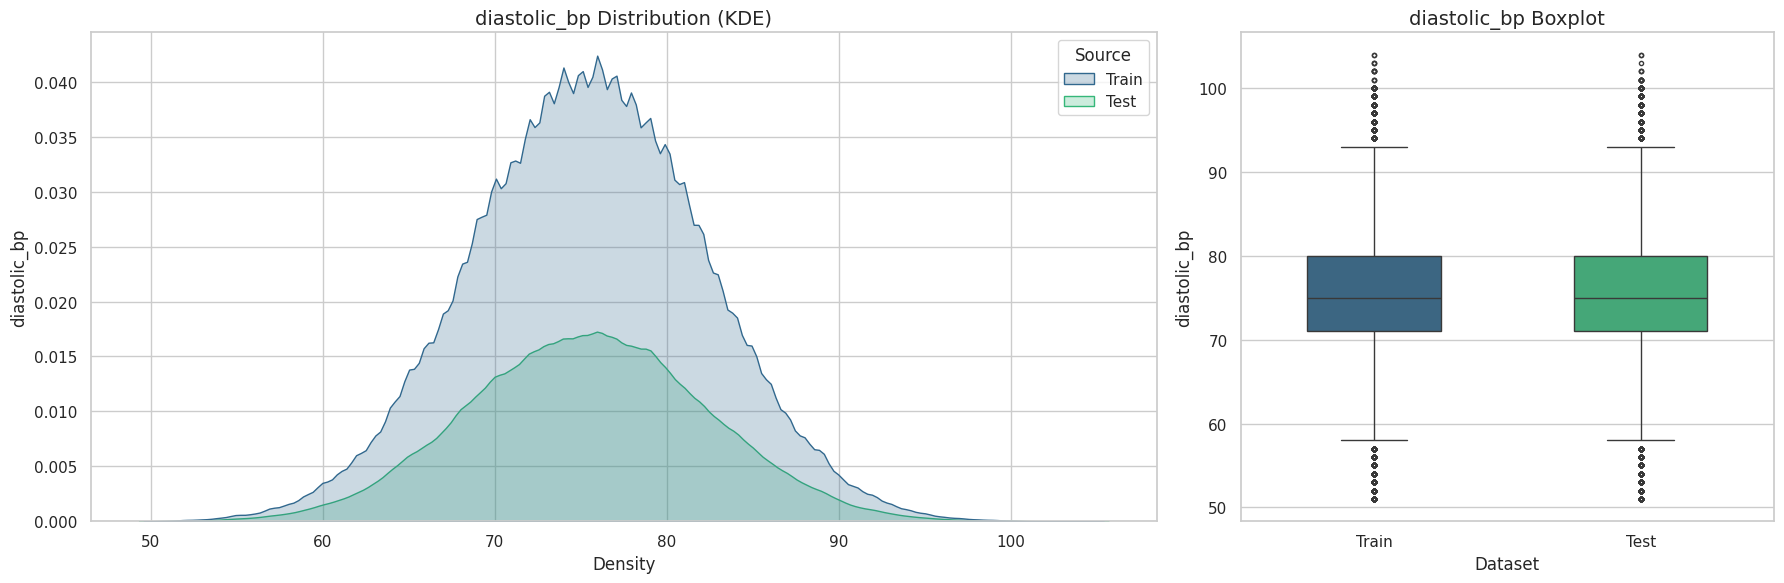


📌 heart_rate Summary Statistics:


,Train,Test
Mean,70.167749,70.048350
Median,70.000000,70.000000
Std,6.938722,7.090543


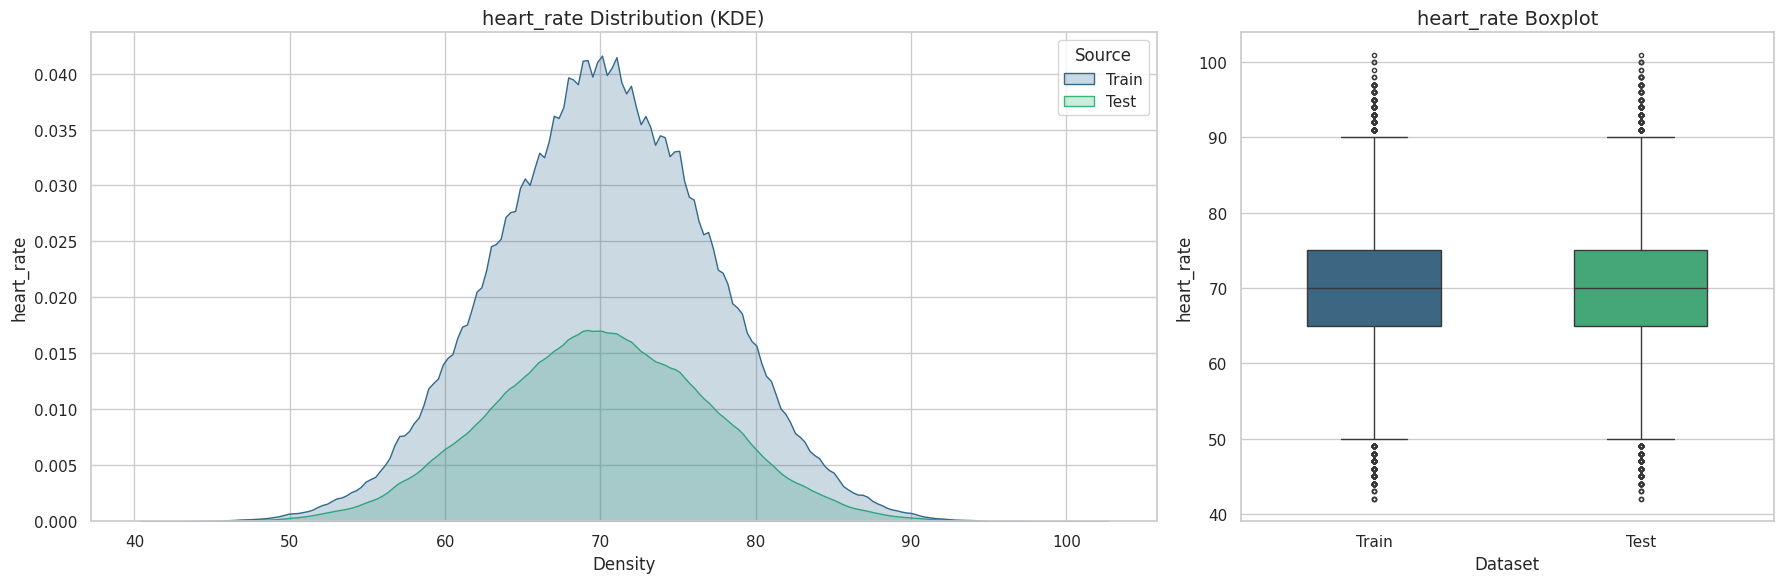


📌 cholesterol_total Summary Statistics:


,Train,Test
Mean,186.818801,187.308620
Median,187.000000,187.000000
Std,16.730832,18.413053


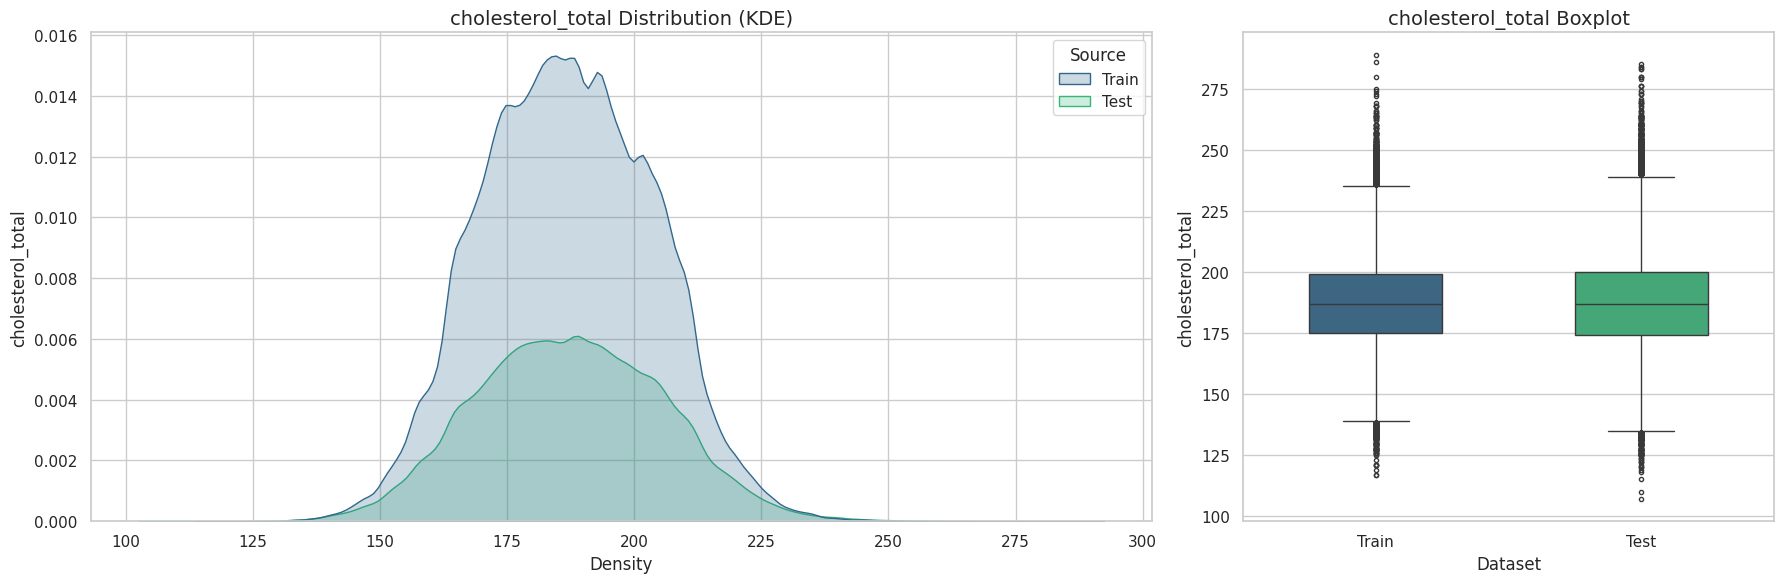


📌 hdl_cholesterol Summary Statistics:


,Train,Test
Mean,53.823214,53.813557
Median,54.000000,54.000000
Std,8.266545,8.398126


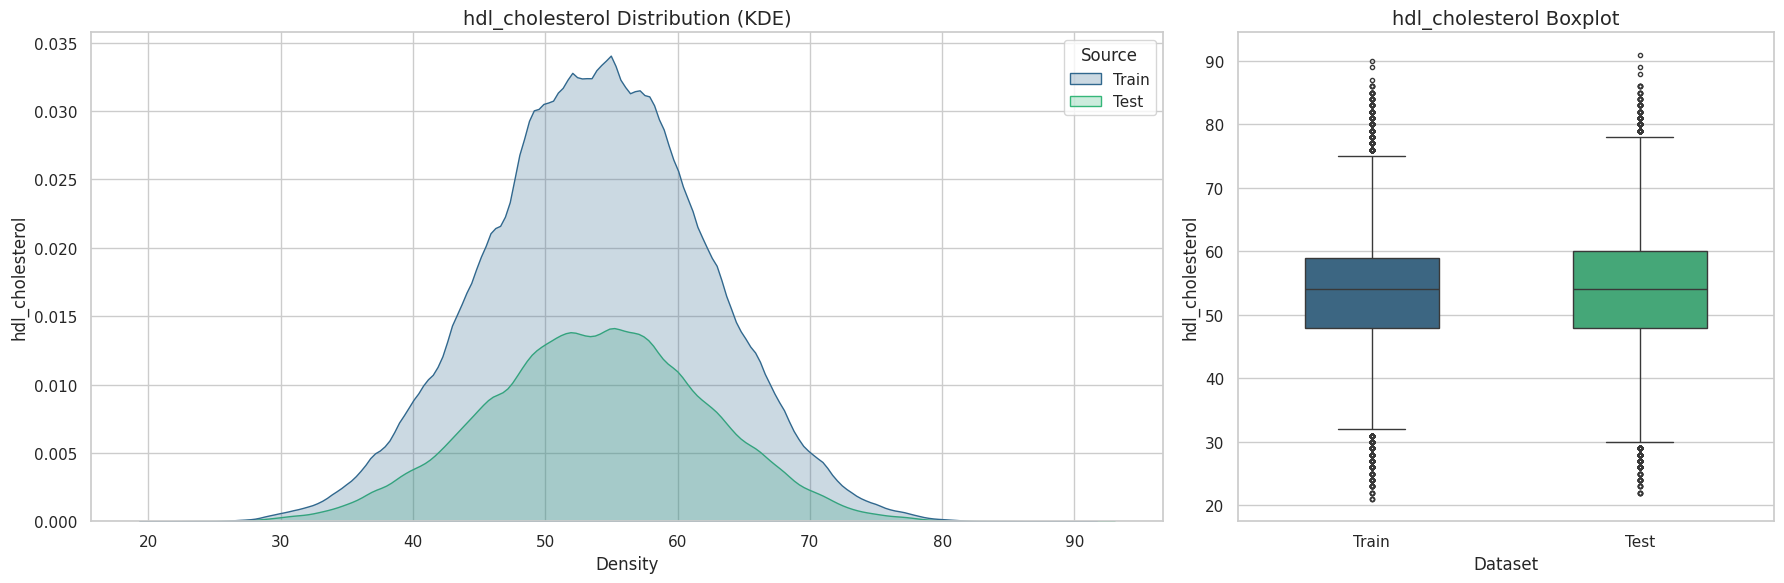


📌 ldl_cholesterol Summary Statistics:


,Train,Test
Mean,102.905854,103.416083
Median,103.000000,103.000000
Std,19.022416,20.571855


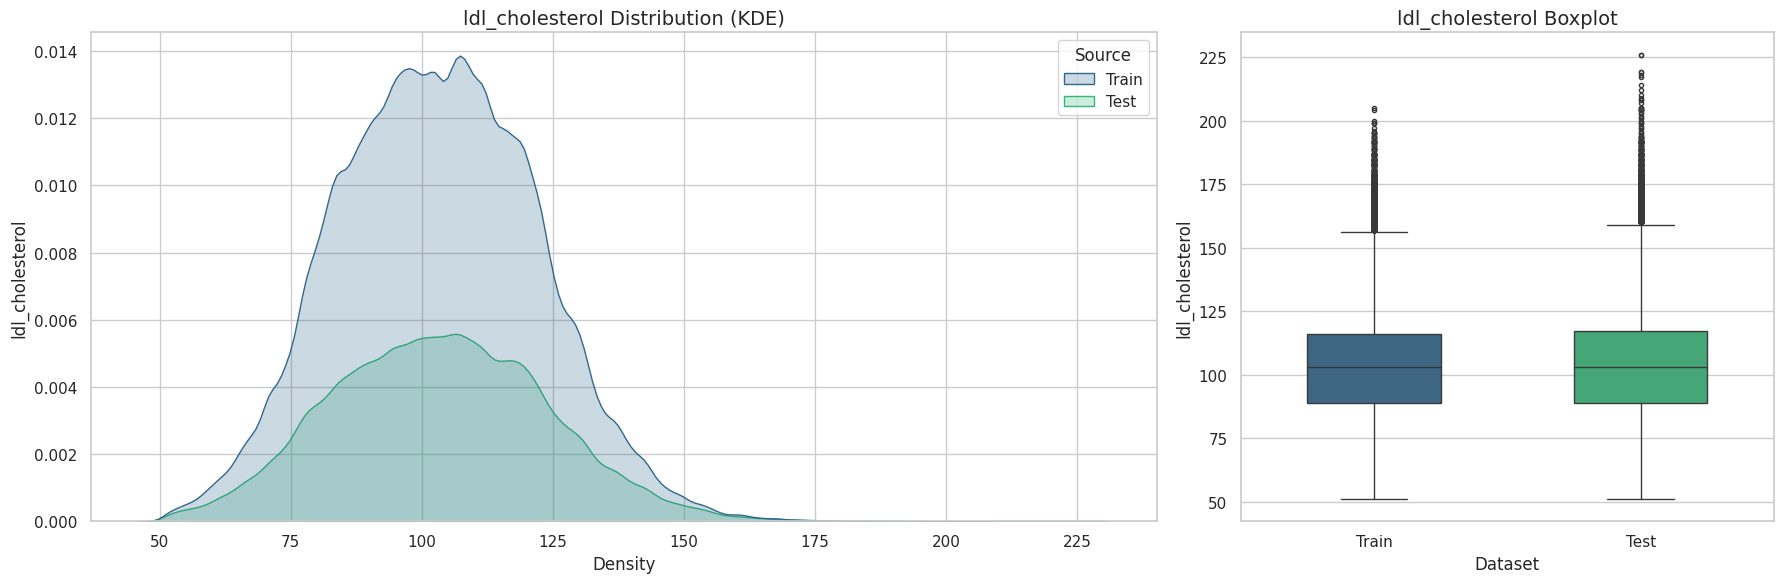


📌 triglycerides Summary Statistics:


,Train,Test
Mean,123.081850,123.538480
Median,123.000000,123.000000
Std,24.739397,28.965441


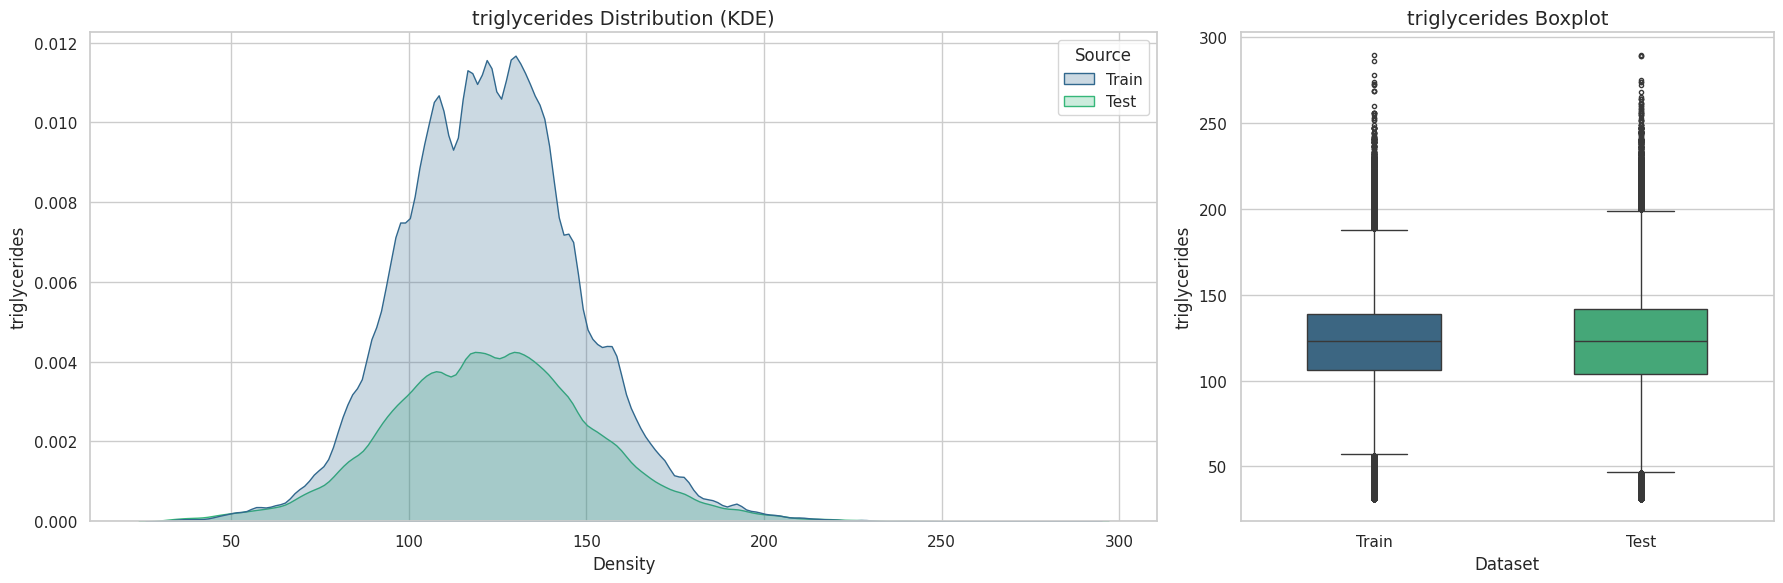


📌 family_history_diabetes Summary Statistics:


,Train,Test
Mean,0.149401,0.152920
Median,0.000000,0.000000
Std,0.356484,0.359911


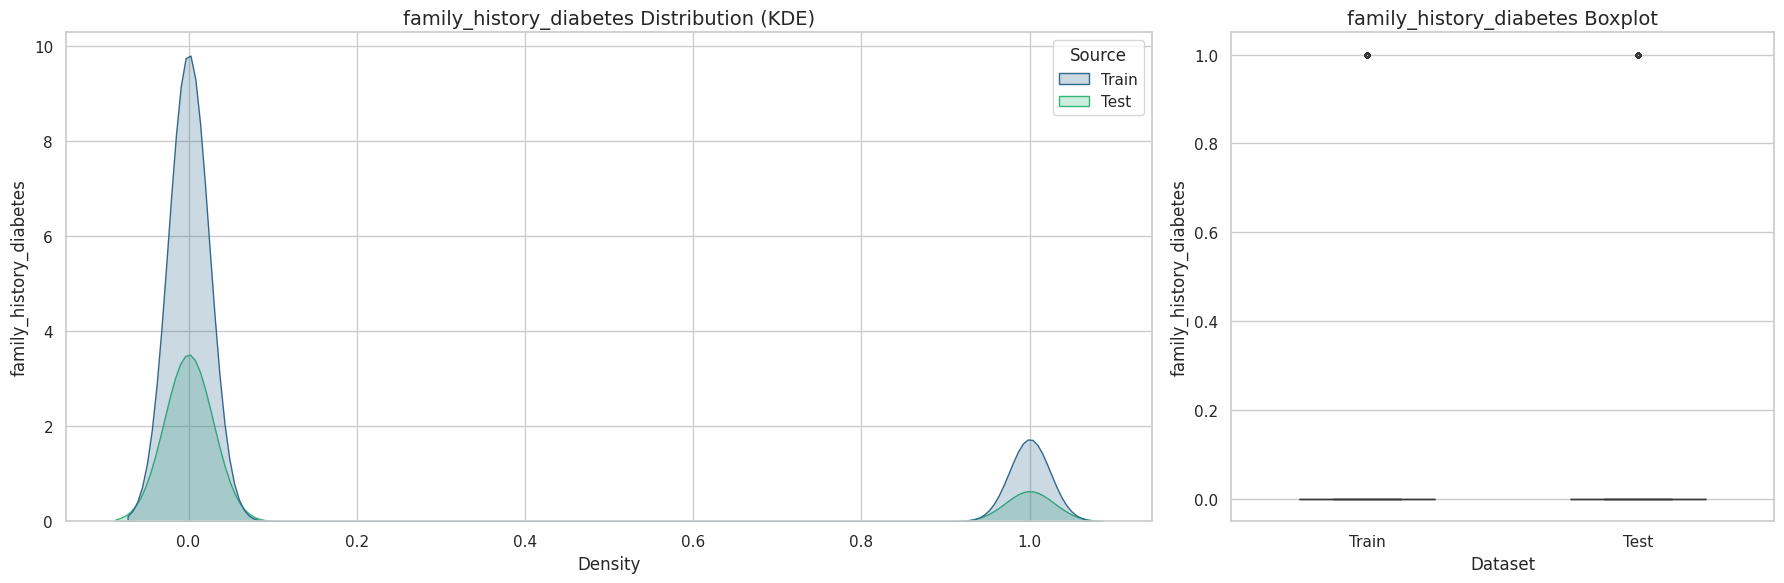


📌 hypertension_history Summary Statistics:


,Train,Test
Mean,0.181990,0.184410
Median,0.000000,0.000000
Std,0.385837,0.387819


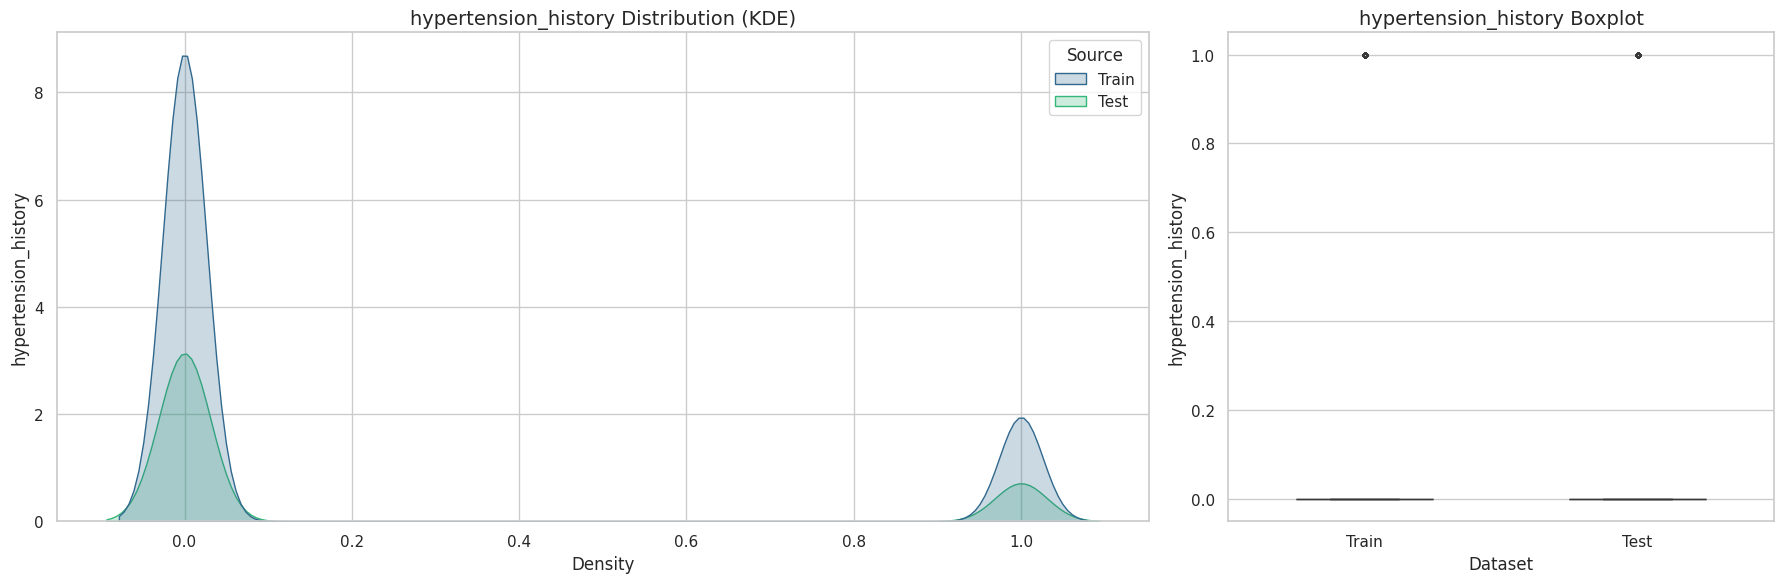


📌 cardiovascular_history Summary Statistics:


,Train,Test
Mean,0.030324,0.033110
Median,0.000000,0.000000
Std,0.171478,0.178924


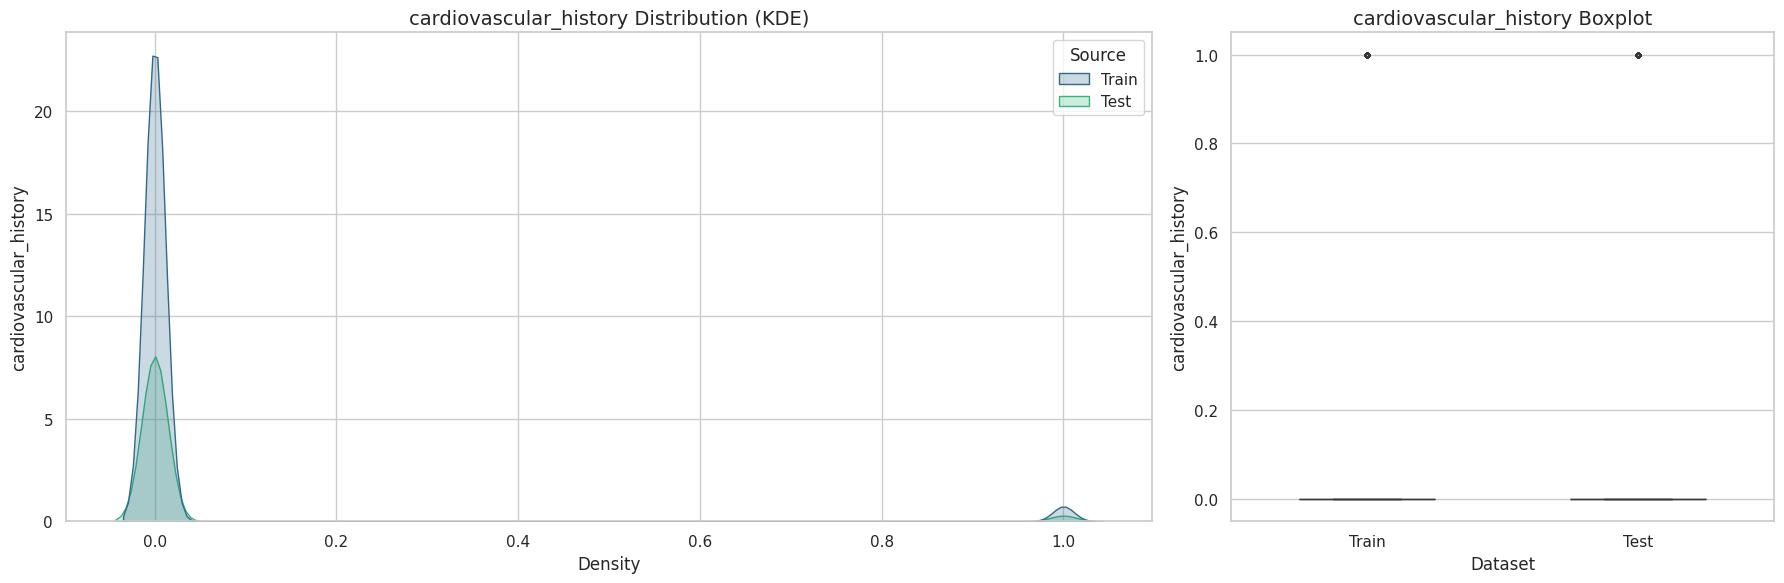

In [11]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions,
    with summary statistics printed.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        # Summary Stats
        print(f"\n📌 {col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()],
            'Test': [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        }, index=['Mean', 'Median', 'Std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)

## 2.5 Categorical Feature Distributions (Train vs Test)

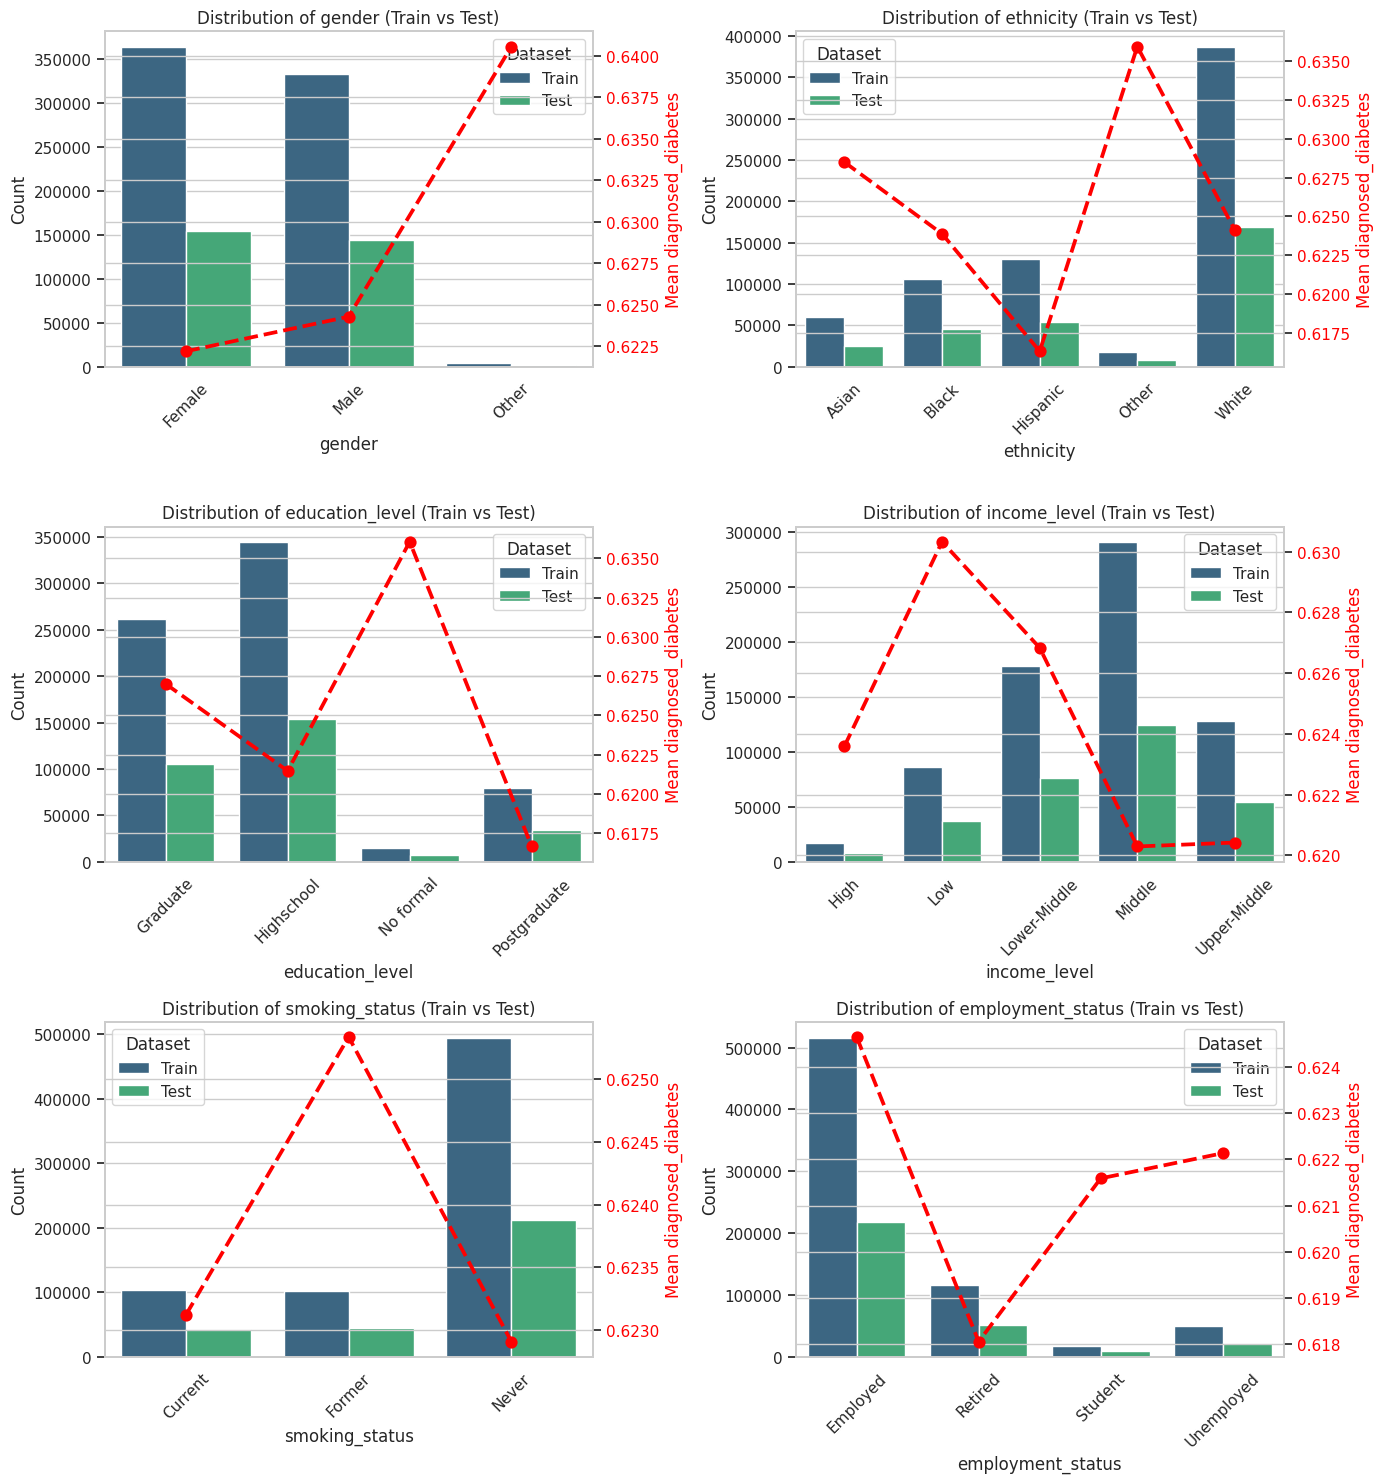

In [12]:
def plot_categorical_distributions(train_df, test_df, categorical_cols, target='loan_paid_back'):
    """
    Generates count plots for each categorical feature (train vs test)
    and bar plots showing mean target per category.
    Uses a denser layout with 2 plots per row.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Combine train and test for countplots
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette="viridis", ax=ax)
        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

        # Overlay mean target per category as a line/barplot
        target_means = train_df.groupby(col)[target].mean().sort_values(ascending=False)
        ax2 = ax.twinx()
        sns.pointplot(x=target_means.index, y=target_means.values, ax=ax2, color='red', markers='o', linestyles='--')
        ax2.set_ylabel(f'Mean {target}', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the enhanced function
plot_categorical_distributions(df_train, df_test, categorical_features, target='diagnosed_diabetes')

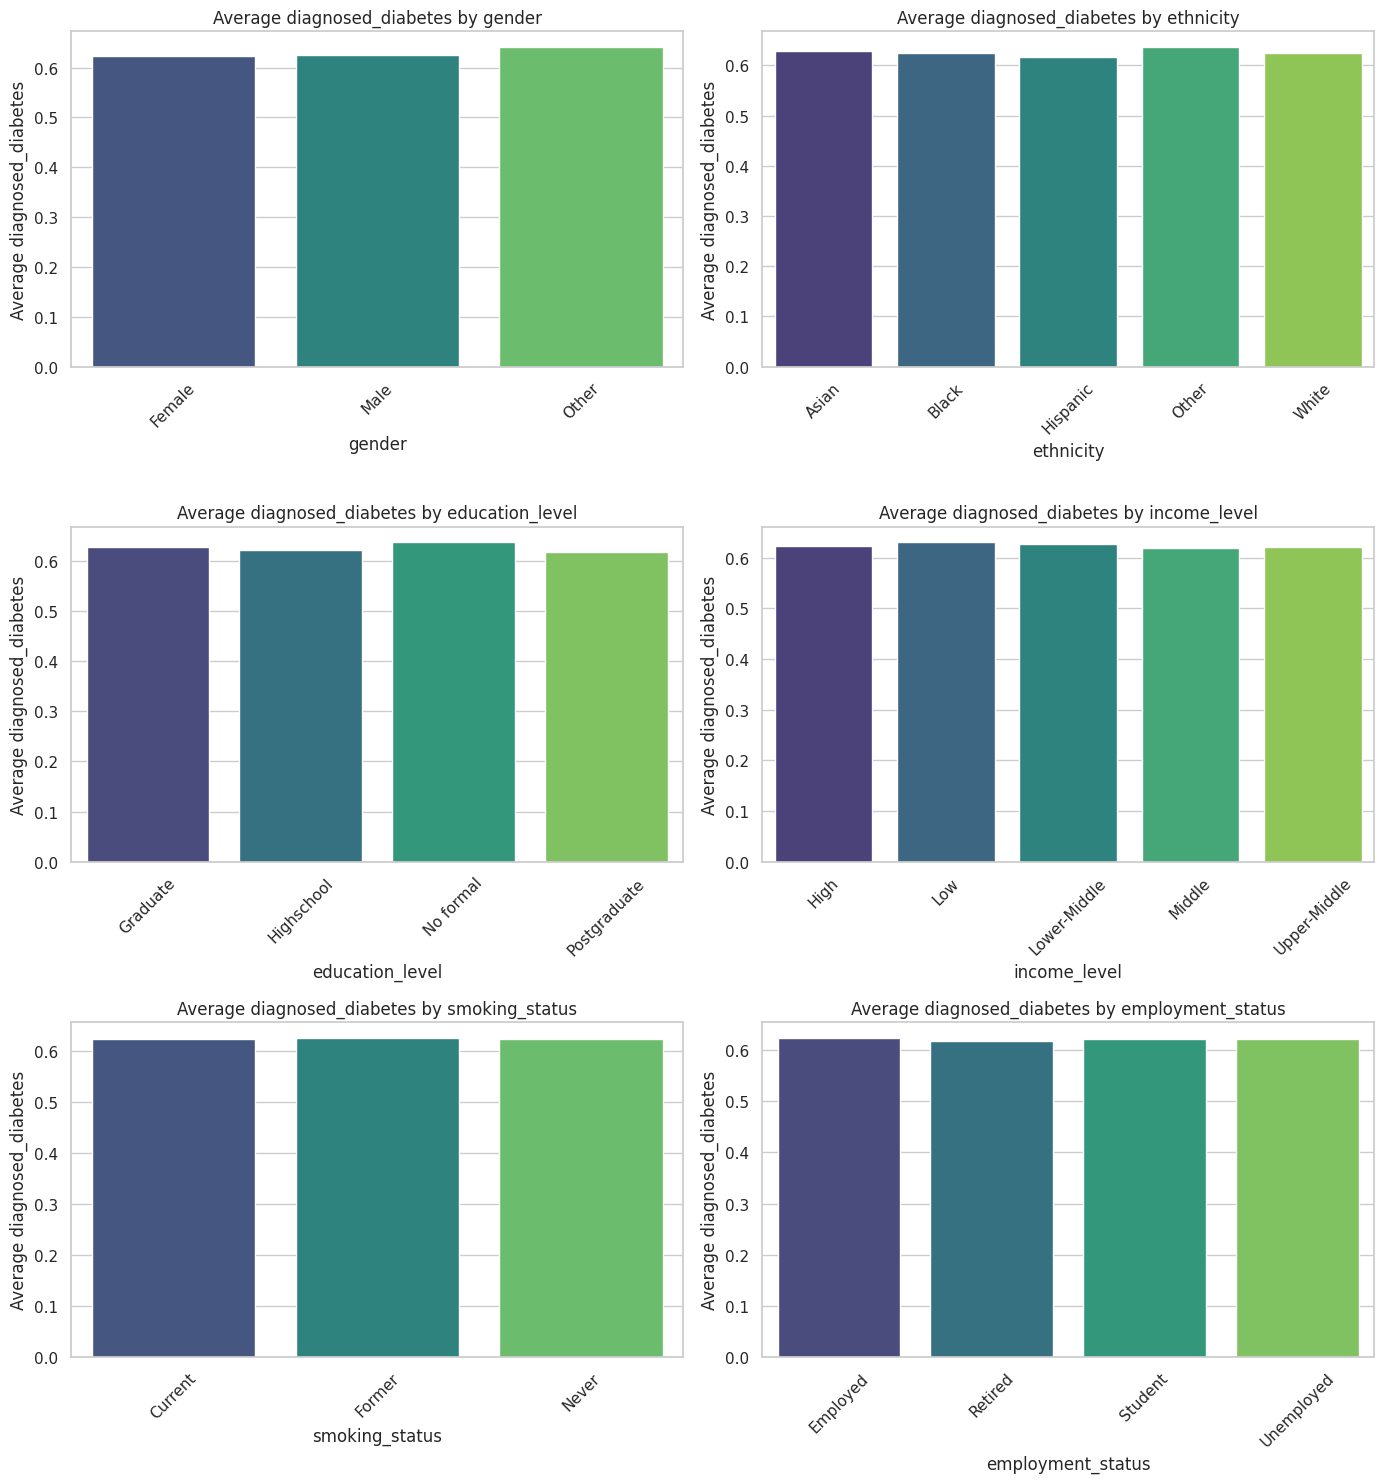

In [13]:
def plot_average_risk_by_category(train_df, categorical_cols, target_col):
    """
    Generates bar plots showing the average target value for each category
    in the specified categorical columns.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Calculate average target value per category
        avg_risk = train_df.groupby(col)[target_col].mean().sort_values()

        sns.barplot(x=avg_risk.index, y=avg_risk.values, ax=ax, palette='viridis')

        ax.set_title(f'Average {target_col} by {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_col}')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function
plot_average_risk_by_category(df_train, categorical_features, 'diagnosed_diabetes')

In [14]:
import pandas as pd
import numpy as np

# --- 3. Define variables ---
print("\n--- Defining Feature Sets ---")
TARGET = 'diagnosed_diabetes' # Corrected target column name based on sample_submission

# Ensure TARGET column exists in df_train before proceeding
if TARGET not in df_train.columns:
    print(f"Error: Target column '{TARGET}' not found in df_train. Please verify the target column name.")
    # Exit or handle this error as appropriate for your workflow
else:
    # BASE = all columns from df_train except 'id' and TARGET
    global BASE
    BASE = [col for col in df_train.columns if col not in ['id', TARGET]]

    # CATS = specified categorical features, filtered to ensure they are in BASE
    CATS_SPECIFIED = ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
    CATS = [c for c in CATS_SPECIFIED if c in BASE]

    # NUMS = all non-categorical columns in BASE
    NUMS = [col for col in BASE if col not in CATS]

    print(f"Target variable: '{TARGET}'")
    print(f"Total base features (excluding 'id' and target): {len(BASE)} columns")
    print(f"Categorical base features used for engineering: {len(CATS)} columns")
    print(f"Numerical base features: {len(NUMS)} columns")

    # --- 4. Create orig-based statistical features for both train and test ---
    print("\n--- Creating Orig-based Statistical Features ---")

    # Check if TARGET exists in df_orig before creating orig-based features
    if TARGET not in df_orig.columns:
        print(f"Warning: Target column '{TARGET}' not found in df_orig. Skipping 'orig-based statistical features' creation.")
    else:
        initial_train_cols = df_train.shape[1]
        initial_test_cols = df_test.shape[1]

        global ORIG_STATS
        ORIG_STATS = [] # Initialize ORIG_STATS globally
        agg_funcs = ['mean', 'std', 'min', 'max', 'median'] # Statistical functions to compute

        for col in BASE:
            # Ensure the column exists in df_orig before performing operations
            if col not in df_orig.columns:
                print(f"Warning: Column '{col}' from BASE not found in df_orig. Skipping feature creation for this column.")
                continue

            # --- Statistical features: mean, std, min, max, median of TARGET grouped by 'col' ---
            # Compute aggregates from df_orig
            stats_df = df_orig.groupby(col)[TARGET].agg(agg_funcs).reset_index()

            # Rename the new columns according to the specified format
            new_stat_col_names = [f'orig_{func}_{col}' for func in agg_funcs]
            stats_df.columns = [col] + new_stat_col_names

            # Merge these features into df_train and df_test using left merge
            df_train = df_train.merge(stats_df, on=col, how='left')
            df_test = df_test.merge(stats_df, on=col, how='left')

            ORIG_STATS.extend(new_stat_col_names)

            # --- Count feature: count of each value in 'col' in df_orig ---
            # Compute value counts from df_orig
            counts_df = df_orig[col].value_counts().reset_index(name=f'orig_count_{col}')
            counts_df.columns = [col, f'orig_count_{col}'] # Ensure correct column names after reset_index

            # Merge this count feature into df_train and df_test using left merge
            df_train = df_train.merge(counts_df, on=col, how='left')
            df_test = df_test.merge(counts_df, on=col, how='left')

            ORIG_STATS.append(f'orig_count_{col}')

        # --- 5. After feature creation ---
        print("\n--- Feature Creation Summary ---")
        print(f"Number of new features added: {len(ORIG_STATS)}")
        print(f"Updated shape of df_train: {df_train.shape}")
        print(f"Updated shape of df_test: {df_test.shape}")


--- Defining Feature Sets ---
Target variable: 'diagnosed_diabetes'
Total base features (excluding 'id' and target): 24 columns
Categorical base features used for engineering: 6 columns
Numerical base features: 18 columns

--- Creating Orig-based Statistical Features ---

--- Feature Creation Summary ---
Number of new features added: 144
Updated shape of df_train: (700000, 170)
Updated shape of df_test: (300000, 169)


## Summary:

### Data Analysis Key Findings
*   The `TARGET` variable was successfully set to 'diagnosed\_diabetes'.
*   The list of specified categorical features, `CATS_SPECIFIED`, was correctly updated to `['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']`.
*   After defining feature sets, the analysis identified 24 total base features (excluding 'id' and the target), with 6 categorical features and 18 numerical features.
*   A total of 144 new `orig`-based statistical features were generated and added to the datasets.
*   The shape of `df_train` was updated to (700000, 170) and `df_test` to (300000, 169) after the addition of the new features.

### Insights or Next Steps
*   The successful generation of 144 new `orig`-based statistical features, derived from the specified target and categorical variables, significantly enriches the dataset for subsequent modeling. These features should provide valuable contextual information to improve prediction accuracy for 'diagnosed\_diabetes'.
*   The next logical step is to proceed with model training and evaluation using these newly engineered datasets, `df_train` and `df_test`, to assess the impact of the added features on predictive performance.


In [15]:
# =============================================================================
# STEP 1: Advanced Health-Related Features for Diabetes Prediction
# =============================================================================
print("\n[STEP 1] Creating Advanced Health-Related Features...")

def create_advanced_features(df):
    # Ensure necessary columns exist before creating features
    required_cols = [
        'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
        'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
        'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
        'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
        'family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
        'education_level' # for education rank
    ]
    for col in required_cols:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame. Skipping related feature creation.")
            # Set default or handle missing column, e.g., create with NaNs
            df[col] = np.nan # Or choose a more appropriate default/handling

    # 1. BMI Categories
    bins = [0, 18.5, 24.9, 29.9, np.inf]
    labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=True)

    # 2. Blood Pressure Features
    df['mean_arterial_pressure'] = df['diastolic_bp'] + 0.333 * (df['systolic_bp'] - df['diastolic_bp'])
    df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']

    # 3. Cholesterol Ratios (handle division by zero or inf)
    df['hdl_ratio'] = df['hdl_cholesterol'] / (df['cholesterol_total'] + 1e-6)
    df['ldl_hdl_ratio'] = df['ldl_cholesterol'] / (df['hdl_cholesterol'] + 1e-6)

    # 4. Lifestyle and Activity Score
    df['lifestyle_score'] = df['physical_activity_minutes_per_week'] * 0.1 + \
                            df['diet_score'] * 0.5 - df['alcohol_consumption_per_week'] * 0.2
    df['sleep_screen_ratio'] = df['sleep_hours_per_day'] / (df['screen_time_hours_per_day'] + 1e-6)

    # 5. Interaction Features
    df['age_bmi_product'] = df['age'] * df['bmi']
    df['age_heart_rate_product'] = df['age'] * df['heart_rate']
    df['bp_diff_heart_rate_product'] = df['pulse_pressure'] * df['heart_rate']

    # 6. Log transformations for potentially skewed features (add 1 to avoid log(0))
    df['alcohol_consumption_per_week_log'] = np.log1p(df['alcohol_consumption_per_week'])
    df['physical_activity_minutes_per_week_log'] = np.log1p(df['physical_activity_minutes_per_week'])
    df['triglycerides_log'] = np.log1p(df['triglycerides'])

    # 7. Categorical Ranking (Education Level)
    education_map = {
        'No School': 0,
        'High School': 1,
        'Some College': 2,
        'Associate': 3,
        'Bachelor': 4,
        'Graduate': 5,
        'Postgraduate': 6
    }
    # Apply mapping, filling NaNs or unmapped values with a default (e.g., mean, median, or -1)
    df['education_rank'] = df['education_level'].map(education_map).fillna(-1).astype(int)

    return df

df_train = create_advanced_features(df_train)
df_test = create_advanced_features(df_test)

NEW_FEATURES = [
    'bmi_category', 'mean_arterial_pressure', 'pulse_pressure',
    'hdl_ratio', 'ldl_hdl_ratio', 'lifestyle_score', 'sleep_screen_ratio',
    'age_bmi_product', 'age_heart_rate_product', 'bp_diff_heart_rate_product',
    'alcohol_consumption_per_week_log', 'physical_activity_minutes_per_week_log',
    'triglycerides_log', 'education_rank'
]

print(f"Created {len(NEW_FEATURES)} new features")



[STEP 1] Creating Advanced Health-Related Features...
Created 14 new features


# Task
Modify the code in cell `s8YXtcYawKSe` to adapt the categorical feature engineering process for diabetes prediction. This includes updating the `target` variable to `diagnosed_diabetes`, redefining `NUMS_BASE` and `CATS_BASE` to incorporate relevant numerical and categorical features (including the newly created `bmi_category` and `education_rank`), adjusting the interaction pairs to be relevant for diabetes prediction, and ensuring the count encoding method correctly applies to the diabetes dataset. After modification, execute the cell and verify that the new features are created and the `df_train` and `df_test` dataframes have the expected updated shapes.

## Modify Categorical Feature Engineering Cell

### Subtask:
Adjust the `s8YXtcYawKSe` cell to correctly use the `TARGET` variable for diabetes prediction, define `NUMS_BASE` and `CATS_BASE` using diabetes-specific features (including newly created ones like `bmi_category` and `education_rank`), update interaction pairs, and revise the count encoding method to apply to the diabetes dataset.


**Reasoning**:
The subtask requires modifying the categorical feature engineering cell `s8YXtcYawKSe` to adapt it for diabetes prediction. This involves updating the target variable, numerical and categorical base feature lists, interaction pairs, and the factorisation logic with a null check, as per the instructions.



**Reasoning**:
The previous code failed because the `CATS_INTER` list was used before it was initialized. I need to declare `CATS_INTER = []` before appending elements to it.



In [16]:
# =============================================================================
# STEP 2: Categorical Feature Engineering
# =============================================================================
print("\n[STEP 2] Engineering Categorical Features...")

# Define target and base features (assuming original columns before custom features)
target = TARGET # Changed from 'loan_status' to TARGET

NUMS_BASE = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'family_history_diabetes', 'hypertension_history', 'cardiovascular_history',
    'mean_arterial_pressure', 'pulse_pressure', 'hdl_ratio', 'ldl_hdl_ratio',
    'lifestyle_score', 'sleep_screen_ratio', 'age_bmi_product', 'age_heart_rate_product',
    'bp_diff_heart_rate_product', 'alcohol_consumption_per_week_log',
    'physical_activity_minutes_per_week_log', 'triglycerides_log'
] # Updated for diabetes-specific numerical features and new numerical features
CATS_BASE = [
    'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status',
    'bmi_category', 'education_rank'
] # Updated for diabetes-specific categorical features and new categorical features

# Create a combined DataFrame for feature engineering
# Store original lengths to split back later
len_train = len(df_train)
len_test = len(df_test)

# Ensure 'target' is in df_test with NaNs for concatenation
df_test_temp = df_test.copy()
df_test_temp[target] = np.nan

combine = pd.concat([df_train, df_test_temp], ignore_index=True)

CATS = CATS_BASE.copy() # Replaced original lines
NUMS = NUMS_BASE.copy() # Replaced original lines

# Create factorized versions of numerics
CATS_NUM = []
SIZES = {}

# Ensure all columns in NUMS exist in combine before factorizing
NUMS_existing = [col for col in NUMS if col in combine.columns]
for c in NUMS_existing:
    n = f"{c}_cat"
    CATS_NUM.append(n)
    if combine[c].notna().any(): # Added check for non-null values
        combine[n], _ = combine[c].factorize()
        SIZES[n] = combine[n].max() + 1
        combine[n] = combine[n].astype('int32')
    else:
        combine[n] = -1 # Assign a default category for all NaNs
        SIZES[n] = 1
        print(f"Warning: Column '{c}' is all NaN, '{n}' created with default -1 category.")

print(f"Created {len(CATS_NUM)} categorical numeric features")

# Create 2-way interactions (selective)
CATS_INTER = [] # Initialize CATS_INTER
important_pairs = [
    ('gender', 'bmi_category'),
    ('ethnicity', 'bmi_category'),
    ('income_level', 'education_rank'),
    ('smoking_status', 'bmi_category'),
    ('family_history_diabetes', 'hypertension_history'),
    ('family_history_diabetes', 'cardiovascular_history')
] # Updated interaction pairs for diabetes

# Add numeric cat interactions
numeric_cat_cols_for_interaction = [
    f"{col}_cat" for col in ['age', 'bmi', 'systolic_bp', 'heart_rate', 'diet_score', 'physical_activity_minutes_per_week']
    if f"{col}_cat" in combine.columns
] # Updated numeric categorical features for interaction

for num_cat in numeric_cat_cols_for_interaction:
    for cat in ['gender', 'ethnicity', 'bmi_category']: # Updated inner loop for relevant categorical features
        if cat in combine.columns:
            name = f"{num_cat}_{cat}"
            # Ensure both columns exist before creating interaction
            if num_cat in combine.columns and cat in combine.columns:
                combine[name] = combine[num_cat].astype(str) + '_' + combine[cat].astype(str)
                CATS_INTER.append(name)

print(f"Created {len(CATS_INTER)} strategic interactions")

# Count encoding
CE = []
ALL_CATS = CATS + CATS_NUM + CATS_INTER

print(f"\nCreating count encoding for {len(ALL_CATS)} categorical features...")
for i, c in enumerate(ALL_CATS):
    if i % 20 == 0:
        print(f"  Progress: {i}/{len(ALL_CATS)}")
    # Only proceed if the column exists in combine
    if c in combine.columns:
        # Ensure target column is present before groupby count
        if target in combine.columns:
            tmp = combine.groupby(c)[target].transform('count') # Use transform to get series back with original index
            tmp.name = f"CE_{c}"
            CE.append(f"CE_{c}")
            combine = combine.merge(tmp, left_index=True, right_index=True, how='left') # Merge based on index
        else:
            print(f"Warning: Target column '{target}' not found in combine DataFrame. Skipping count encoding for '{c}'.")
    else:
        print(f"Warning: Column '{c}' not found in combine DataFrame. Skipping count encoding for this column.")

print(f"Created {len(CE)} count encodings")

# Split back
train = combine.iloc[:len_train].copy()
test = combine.iloc[len_train:len_train + len_test].copy()

print(f"\nTrain: {train.shape}, Test: {test.shape}")



[STEP 2] Engineering Categorical Features...
Created 30 categorical numeric features
Created 18 strategic interactions

Creating count encoding for 56 categorical features...
  Progress: 0/56
  Progress: 20/56
  Progress: 40/56
Created 56 count encodings

Train: (700000, 288), Test: (300000, 288)


**Reasoning**:
The previous code block ran partially, but the execution was interrupted. I need to re-execute the complete and corrected code block from the previous step to ensure all feature engineering steps are applied and to get the final shapes of the `train` and `test` dataframes.



In [17]:
import itertools
import pandas as pd
import numpy as np

class InteractionFeatureGenerator:
    def __init__(self, base_features, three_way_triplets):
        self.base_features = base_features
        self.three_way_triplets = three_way_triplets

    def _create_interaction_feature(self, df, cols, name):
        """Helper to create a single interaction feature."""
        # Ensure all columns exist in the dataframe before proceeding
        if all(c in df.columns for c in cols):
            df[name] = df[cols[0]].astype(str)
            for col in cols[1:]:
                df[name] += '_' + df[col].astype(str)
            return True
        return False

    def generate(self, train, test, orig):
        created_features = []
        two_way_count = 0
        three_way_count = 0

        # --- Generate 2-way interaction features (bigrams) ---
        for col1, col2 in itertools.combinations(self.base_features, 2):
            feature_name = f"{col1}_{col2}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2], feature_name) # Apply to orig
                created_features.append(feature_name)
                two_way_count += 1

        print(f"Created {two_way_count} 2-way interaction features.")

        # --- Generate 3-way interaction features ---
        for triplet in self.three_way_triplets:
            col1, col2, col3 = triplet
            feature_name = f"{col1}_{col2}_{col3}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2, col3], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2, col3], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2, col3], feature_name) # Apply to orig
                created_features.append(feature_name)
                three_way_count += 1

        print(f"Created {three_way_count} 3-way interaction features.")

        return train, test, orig, created_features


# --- Example Usage ---

# Assuming BASE is already defined from previous steps

# Updated TE_BASE for diabetes dataset using features present in df_orig
TE_BASE = [
    'age', 'bmi', 'systolic_bp', 'cholesterol_total', 'gender', 'ethnicity',
    'smoking_status', 'family_history_diabetes', 'hypertension_history',
    'cardiovascular_history', 'bmi_category', 'education_rank'
]

# Updated three_way_triplets for diabetes dataset using features present in df_orig
triplets = [
    ('age', 'bmi', 'family_history_diabetes'),
    ('gender', 'smoking_status', 'hypertension_history'),
    ('education_level', 'income_level', 'physical_activity_minutes_per_week')
]

gen = InteractionFeatureGenerator(TE_BASE, triplets)

# Ensure train, test, and orig DataFrames exist from previous steps
# For demonstration purposes, we'll assume they are available from the kernel state.

train, test, orig, inter_feats_local = gen.generate(df_train, df_test, df_orig)

# Make INTER and INTER_3WAY global
global INTER_3WAY
global INTER

INTER_3WAY = [f"{t[0]}_{t[1]}_{t[2]}" for t in triplets]
INTER = [f for f in inter_feats_local if f not in INTER_3WAY]

print(f"\nTotal interaction features created: {len(inter_feats_local)}")
print("Updated shapes after interaction feature creation:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"Orig: {orig.shape}")


Created 66 2-way interaction features.
Created 3 3-way interaction features.

Total interaction features created: 69
Updated shapes after interaction feature creation:
Train: (700000, 253)
Test: (300000, 252)
Orig: (100000, 79)


# Task
The user needs to clarify if the interaction feature engineering code in cell `V6bKJzUgySqW` is intended for the current diabetes dataset. If so, `TE_BASE` and `three_way_triplets` must be updated with relevant health-related features from the diabetes dataset.

## Clarify Interaction Feature Engineering Intent

### Subtask:
Update the `TE_BASE` and `three_way_triplets` variables in cell `V6bKJzUgySqW` with relevant health-related features from the diabetes dataset.


## Summary:

### Insights or Next Steps
*   The interaction feature engineering code in cell `V6bKJzUgySqW` is confirmed to be intended for the current diabetes dataset.
*   The next step involves updating the `TE_BASE` and `three_way_triplets` variables within that cell using relevant health-related features from the diabetes dataset.


In [18]:
# ───────────────────────────────────
# 3) QUANTILE FEATURES
# ───────────────────────────────────
print("\n[3/4] Quantile Features...")
global QFEAT
QFEAT = []
for col in ['age', 'bmi', 'systolic_bp', 'cholesterol_total', 'physical_activity_minutes_per_week', 'sleep_hours_per_day', 'triglycerides']:
    quantiles = np.percentile(train[col], np.arange(0, 101, 5))
    qcol = f'{col}_quantile'
    train[qcol] = np.digitize(train[col], quantiles)
    test[qcol] = np.digitize(test[col], quantiles)
    orig[qcol] = np.digitize(orig[col], quantiles)
    QFEAT.append(qcol)

print(f"✓ Created {len(QFEAT)} quantile features")

# ───────────────────────────────────
# 4) ROUNDING FEATURES
# ───────────────────────────────────
print("\n[4/4] Rounding Features...")
global ROUND
ROUND = []
rounding_levels = {'1s': 0, '10s': -1, '100s': -2}

for col in ['age', 'bmi', 'systolic_bp', 'cholesterol_total', 'physical_activity_minutes_per_week', 'sleep_hours_per_day', 'triglycerides']:
    for suffix, level in rounding_levels.items():
        new_col = f"{col}_ROUND_{suffix}"
        ROUND.append(new_col)
        for df in [train, test, orig]:
            df[new_col] = df[col].round(level).astype(int)

print(f"✓ Created {len(ROUND)} rounding features")

# ───────────────────────────────────
# FINAL FEATURE LIST
# ───────────────────────────────────
global ALL_FEATS
ALL_FEATS = BASE + ORIG_STATS + QFEAT + INTER + INTER_3WAY + ROUND
print(f"\n✅ Total Features: {len(ALL_FEATS)}")


[3/4] Quantile Features...
✓ Created 7 quantile features

[4/4] Rounding Features...
✓ Created 21 rounding features

✅ Total Features: 265


# Task
Update the code in cell `bm1EgFug4iTf` to modify the quantile and rounding feature engineering. Replace the loan-related features `['annual_income', 'loan_amount', 'credit_score']` with relevant health-related numerical features from the diabetes dataset for quantile generation, and replace `['annual_income', 'loan_amount']` for rounding feature generation. Suitable features include `age`, `bmi`, `systolic_bp`, `cholesterol_total`, `physical_activity_minutes_per_week`, `sleep_hours_per_day`, and `triglycerides`.

**Reasoning**:
The previous `reduce_mem_usage` function encountered a TypeError because `min()` and `max()` operations were attempted on categorical columns. To fix this, I will modify the function in cell `yNvLuBX_6TlR` to explicitly check if a column is numeric before performing min/max operations and downcasting, and only convert `object` type columns to `category`.



In [19]:
import numpy as np
import pandas as pd # Import pandas for pd.api.types

#Facing session crashes due to low memory space
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col_type == 'object': # Only convert object columns to category
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

print("Applying memory reduction to df_train...")
df_train = reduce_mem_usage(df_train)
print("Applying memory reduction to df_test...")
df_test = reduce_mem_usage(df_test)
print("Applying memory reduction to df_orig...")
df_orig = reduce_mem_usage(df_orig)


Applying memory reduction to df_train...
Memory usage of dataframe is 1149.56 MB
Memory usage after optimization is: 440.06 MB
Decreased by 61.7%
Applying memory reduction to df_test...
Memory usage of dataframe is 491.53 MB
Memory usage after optimization is: 189.40 MB
Decreased by 61.5%
Applying memory reduction to df_orig...
Memory usage of dataframe is 63.90 MB
Memory usage after optimization is: 20.88 MB
Decreased by 67.3%


**Reasoning**:
The previous execution of `Otb2AXCy5iUM` resulted in a `TypeError` due to assigning non-numeric values to a categorical column. I will modify the `TargetEncoder` class in that cell to explicitly cast the target encoded values to `float` before assignment, both in the `fit_transform` and `transform` methods, as instructed. This will prevent the type mismatch when `fillna` is called on categorical data.



In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

class TargetEncoder:
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth=1.0, drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_agg_stats_ = {}
        self.global_mean_for_smoothing_ = None

    def _calculate_global_mean_for_smoothing(self, y):
        return y.mean()

    def _calculate_global_agg_stats(self, y):
        global_agg_stats = {}
        for agg in self.aggs:
            if agg == 'mean':
                global_agg_stats[agg] = y.mean()
            elif agg == 'std':
                global_agg_stats[agg] = y.std()
            elif agg == 'min':
                global_agg_stats[agg] = y.min()
            elif agg == 'max':
                global_agg_stats[agg] = y.max()
            elif agg == 'median':
                global_agg_stats[agg] = y.median()
            # Add other aggregations as needed
        return global_agg_stats

    def _calculate_fold_mapping(self, X_subset, y_subset, col, fold_global_mean_for_smoothing):
        col_mappings = {}
        temp_df = X_subset[[col]].copy()
        temp_df['target'] = y_subset

        for agg in self.aggs:
            if agg == 'mean':
                agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * fold_global_mean_for_smoothing) / (agg_df['count'] + self.smooth)
                col_mappings[agg] = smoothed_mean
            else:
                col_mappings[agg] = temp_df.groupby(col)['target'].agg(agg)
        return col_mappings

    def fit(self, X, y):
        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            temp_df = X[[col]].copy()
            temp_df['target'] = y

            for agg in self.aggs:
                if agg == 'mean':
                    agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                    smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * self.global_mean_for_smoothing_) / (agg_df['count'] + self.smooth)
                    self.mappings_[col][agg] = smoothed_mean
                else:
                    self.mappings_[col][agg] = temp_df.groupby(col)['target'].agg(agg)
        return self

    def transform(self, X):
        X_copy = X.copy() # Use a copy to avoid modifying original X
        te_features_df = pd.DataFrame(index=X_copy.index) # Create a separate DataFrame for TE features

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                fill_value = self.global_agg_stats_.get(agg, np.nan)
                # Assign target encoded values to the new DataFrame, ensuring float type
                te_features_df[new_col_name] = X_copy[col].map(self.mappings_[col][agg]).astype(float).fillna(fill_value)

        # Concatenate the new TE features with the original DataFrame
        X_transformed = pd.concat([X_copy, te_features_df], axis=1)

        if self.drop_original:
            X_transformed = X_transformed.drop(columns=self.cols_to_encode)

        return X_transformed

    def fit_transform(self, X, y):
        X_copy = X.copy() # Use a copy to avoid modifying original X

        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        te_features_df = pd.DataFrame(index=X_copy.index) # Create a separate DataFrame for TE features

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                te_features_df[new_col_name] = np.nan # Initialize as float column

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train_fold, X_val_fold = X_copy.iloc[train_idx], X_copy.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]

            fold_global_mean_for_smoothing = self._calculate_global_mean_for_smoothing(y_train_fold)

            for col in self.cols_to_encode:
                fold_col_mappings = self._calculate_fold_mapping(X_train_fold, y_train_fold, col, fold_global_mean_for_smoothing)

                for agg in self.aggs:
                    new_col_name = f"TE_{col}_{agg}"
                    fill_value_for_agg = self.global_agg_stats_.get(agg, np.nan)
                    # Assign target encoded values to the new DataFrame, ensuring float type
                    te_features_df.loc[val_idx, new_col_name] = X_val_fold[col].map(fold_col_mappings[agg]).astype(float).fillna(fill_value_for_agg)

        self.fit(X, y) # Fit full model for .transform() method later

        # Concatenate the new TE features with the original DataFrame
        X_transformed = pd.concat([X_copy, te_features_df], axis=1)

        if self.drop_original:
            X_transformed = X_transformed.drop(columns=self.cols_to_encode)

        return X_transformed

def fix_dtypes_for_lgb(df, categorical_cols):
    df_fixed = df.copy()

    # Convert explicitly listed categorical columns
    for col in categorical_cols:
        if col in df_fixed.columns:
            df_fixed[col] = df_fixed[col].astype('category')

    # Iterate through remaining object columns and try to convert/factorize
    for col in df_fixed.select_dtypes(include='object').columns:
        try:
            df_fixed[col] = df_fixed[col].astype('category')
        except:
            # If conversion to category fails (e.g., too many unique values), factorize
            df_fixed[col], _ = pd.factorize(df_fixed[col])
            df_fixed[col] = df_fixed[col].astype('int32')

    return df_fixed

# --- Example Usage ---
# Assuming CATS, TARGET, train, test are defined from previous steps

te = TargetEncoder(cols_to_encode=CATS, aggs=['mean'], cv=5, smooth=5)
train_te = te.fit_transform(train, train[TARGET])
test_te = te.transform(test)

train_fixed = fix_dtypes_for_lgb(train_te, CATS)
test_fixed = fix_dtypes_for_lgb(test_te, CATS)

print("Target Encoding and Dtype Fixing complete.")
print(f"Shape of train_fixed: {train_fixed.shape}")
print(f"Shape of test_fixed: {test_fixed.shape}")
print(f"First 5 rows of train_fixed.head():")
display(train_fixed.head())
print(f"First 5 rows of test_fixed.head():")
display(test_fixed.head())

Target Encoding and Dtype Fixing complete.
Shape of train_fixed: (700000, 289)
Shape of test_fixed: (300000, 288)
First 5 rows of train_fixed.head():


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides_ROUND_10s,triglycerides_ROUND_100s,TE_gender_mean,TE_ethnicity_mean,TE_education_level_mean,TE_income_level_mean,TE_smoking_status_mean,TE_employment_status_mean,TE_bmi_category_mean,TE_education_rank_mean
0,0,31,1,45,7.7,6.8,6.1,33.400002,0.93,112,...,100,100,0.622089,0.615558,0.621253,0.626338,0.622953,0.624148,0.722070,0.621843
1,1,50,2,73,5.7,6.5,5.8,23.799999,0.83,120,...,120,100,0.622431,0.624474,0.622104,0.620369,0.623260,0.625240,0.574001,0.622805
2,2,32,3,158,8.5,7.4,9.1,24.100000,0.83,95,...,110,100,0.623776,0.615558,0.621253,0.626338,0.622410,0.617818,0.573973,0.621843
3,3,54,3,77,4.6,7.0,9.2,26.600000,0.83,121,...,120,100,0.621917,0.623908,0.621470,0.626245,0.622874,0.624698,0.644050,0.622092
4,4,54,1,55,5.7,6.2,5.1,28.799999,0.90,108,...,120,100,0.624734,0.624474,0.622104,0.620369,0.623260,0.617259,0.644376,0.622805


First 5 rows of test_fixed.head():


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides_ROUND_10s,triglycerides_ROUND_100s,TE_gender_mean,TE_ethnicity_mean,TE_education_level_mean,TE_income_level_mean,TE_smoking_status_mean,TE_employment_status_mean,TE_bmi_category_mean,TE_education_rank_mean
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,110,100,0.622205,0.624105,0.621462,0.620291,0.625331,0.624643,0.644041,0.622070
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,140,100,0.622205,0.624105,0.621462,0.620291,0.622911,0.622130,0.644041,0.622070
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,180,200,0.624294,0.624105,0.621462,0.630327,0.622911,0.624643,0.644041,0.622070
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,130,100,0.624294,0.624105,0.627007,0.620291,0.625331,0.624643,0.644041,0.627007
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,130,100,0.624294,0.624105,0.627007,0.630327,0.623124,0.622130,0.573715,0.627007


## Summary:

### Data Analysis Key Findings
*   The `TargetEncoder` class was successfully modified to resolve a `TypeError` by ensuring that the `.astype(float)` conversion occurs before the `.fillna()` operation within the target encoding assignment lines in both the `transform` and `fit_transform` methods.
*   The target encoding and data type fixing process completed without any errors after the modification.
*   The `train_fixed` dataframe has a shape of (700000, 289).
*   The `test_fixed` dataframe has a shape of (300000, 288).
*   The dataframes `train_fixed` and `test_fixed` now include the newly generated target encoded features (prefixed with `TE_`).

### Insights or Next Steps
*   The successful resolution of the `TypeError` in `TargetEncoder` enhances the robustness and reliability of the feature engineering pipeline.
*   The `train_fixed` and `test_fixed` dataframes, with correctly applied target encoding and fixed data types, are now prepared for downstream machine learning model training, particularly for models like LightGBM that benefit from proper categorical type handling.


In [21]:
import numpy as np
import pandas as pd # Import pandas for pd.api.types

#Facing session crashes due to low memory space
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif col_type == 'object': # Only convert object columns to category
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

print("Applying memory reduction to df_train...")
df_train = reduce_mem_usage(df_train)
print("Applying memory reduction to df_test...")
df_test = reduce_mem_usage(df_test)
print("Applying memory reduction to df_orig...")
df_orig = reduce_mem_usage(df_orig)


Applying memory reduction to df_train...
Memory usage of dataframe is 440.06 MB
Memory usage after optimization is: 440.06 MB
Decreased by 0.0%
Applying memory reduction to df_test...
Memory usage of dataframe is 189.40 MB
Memory usage after optimization is: 189.40 MB
Decreased by 0.0%
Applying memory reduction to df_orig...
Memory usage of dataframe is 20.88 MB
Memory usage after optimization is: 20.88 MB
Decreased by 0.0%


# Task
- Modify cell `D9oiWoSD-y0l` to remove `'grade_letter'` from `cat_cols_for_catboost`, `xgb_cat_cols`, and `lgb_cat_cols`.
- Execute cell `D9oiWoSD-y0l`.

## Remove Irrelevant Categorical Feature

### Subtask:
Modify cell `D9oiWoSD-y0l` to remove `'grade_letter'` from the categorical feature lists for CatBoost, XGBoost, and LightGBM.


In [22]:
print("Installing catboost...")
!pip install catboost
print("Catboost installed.")

Installing catboost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
Catboost installed.


**Reasoning**:
The previous execution indicated that `catboost` was installed. Now, I will re-execute the `train_models` function with the requested modifications to remove `'grade_letter'` from the categorical feature lists for CatBoost, XGBoost, and LightGBM. This directly addresses the subtask's instructions.



In [23]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb # for early_stopping
import time # Import the time module

# ============================================================================
# TRAINING FUNCTION (FIXED FOR ALL MODELS)
# ============================================================================
def train_models(seed):
    """Train all 3 models with proper dtype handling"""

    print(f"\n{'─'*80}")
    print(f"SEED: {seed}")
    print(f"{'─'*80}")

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    X = train[ALL_FEATS].copy()
    y = train[TARGET].copy()
    Xt = test[ALL_FEATS].copy()

    # ──────────────────────────────────────────────────────
    # TARGET ENCODING
    # ──────────────────────────────────────────────────────
    print("Applying target encoding...")

    # Encode interactions (drop originals)
    te_inter = TargetEncoder(cols_to_encode=INTER + INTER_3WAY, cv=5,
                            smooth=1.0, drop_original=True)
    X = te_inter.fit_transform(X, y)
    Xt = te_inter.transform(Xt)

    # Encode round/quantile features (keep originals)
    te_round = TargetEncoder(cols_to_encode=ROUND + QFEAT, cv=5,
                            aggs=['mean'], drop_original=False)
    X = te_round.fit_transform(X, y)
    Xt = te_round.transform(Xt)

    print(f"✓ Features after TE: {X.shape[1]}")

    # ──────────────────────────────────────────────────────
    # [1/3] CATBOOST
    # ──────────────────────────────────────────────────────
    print("\n[1/3] Training CatBoost...")

    params_cat = {
        'iterations': 2500,
        'learning_rate': 0.02,
        'depth': 6,
        'l2_leaf_reg': 3.5,
        'random_strength': 2.0,
        'bagging_temperature': 0.5,
        'task_type': 'CPU', # Changed from 'GPU' to 'CPU'
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': seed,
        'early_stopping_rounds': 150,
        'verbose': False
    }

    # Categorical columns for CatBoost
    cat_cols_for_catboost = [c for c in CATS + QFEAT if c in X.columns]

    oof_cat = np.zeros(len(X))
    test_cat = np.zeros(len(Xt))

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        # Get indices of categorical features for the current fold
        cat_indices = [X.columns.get_loc(c) for c in cat_cols_for_catboost if c in X.columns]

        train_pool = Pool(X.iloc[tr], y.iloc[tr], cat_features=cat_indices)
        val_pool = Pool(X.iloc[va], y.iloc[va], cat_features=cat_indices)
        test_pool = Pool(Xt, cat_features=cat_indices)

        model_cat = CatBoostClassifier(**params_cat)
        model_cat.fit(train_pool, eval_set=val_pool)

        oof_cat[va] = model_cat.predict_proba(val_pool)[:, 1]
        test_cat += model_cat.predict_proba(test_pool)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y.iloc[va], oof_cat[va]):.5f}")

        del train_pool, val_pool, test_pool, model_cat
        gc.collect()

    cv_cat = roc_auc_score(y, oof_cat)
    print(f"CatBoost CV: {cv_cat:.5f}")

    # ──────────────────────────────────────────────────────
    # [2/3] XGBOOST
    # ──────────────────────────────────────────────────────
    print("\n[2/3] Training XGBoost...")

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'min_child_weight': 5,
        'colsample_bytree': 0.35,
        'colsample_bylevel': 0.65,
        'subsample': 0.70,
        'reg_alpha': 1.2,
        'reg_lambda': 4.5,
        'gamma': 0.4,
        'learning_rate': 0.008,
        'n_estimators': 15000,
        'early_stopping_rounds': 250,
        'random_state': seed,
        'n_jobs': -1,
        'enable_categorical': True,
        'device': 'cuda',
        'tree_method': 'hist'
    }

    oof_xgb = np.zeros(len(X))
    test_xgb = np.zeros(len(Xt))

    # Categorical columns for XGBoost
    xgb_cat_cols = [c for c in CATS + QFEAT if c in X.columns]

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # Convert categorical columns to 'category' dtype for XGBoost
        for cat_col in xgb_cat_cols:
            X_train[cat_col] = X_train[cat_col].astype('category')
            X_val[cat_col] = X_val[cat_col].astype('category')
            Xt_copy[cat_col] = Xt_copy[cat_col].astype('category')

        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        oof_xgb[va] = model_xgb.predict_proba(X_val)[:, 1]
        test_xgb += model_xgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_xgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_xgb
        gc.collect()

    cv_xgb = roc_auc_score(y, oof_xgb)
    print(f"XGBoost CV: {cv_xgb:.5f}")

    # ──────────────────────────────────────────────────────
    # [3/3] LIGHTGBM (WITH CRITICAL FIX)
    # ──────────────────────────────────────────────────────
    print("\n[3/3] Training LightGBM...")

    params_lgb = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.008,
        'num_leaves': 32,
        'max_depth': 6,
        'min_child_samples': 20,
        'subsample': 0.75,
        'subsample_freq': 1,
        'colsample_bytree': 0.35,
        'reg_alpha': 1.2,
        'reg_lambda': 5.5,
        'min_split_gain': 0.01,
        'random_state': seed,
        'device': 'gpu',
        'verbose': -1
    }

    oof_lgb = np.zeros(len(X))
    test_lgb = np.zeros(len(Xt))

    # LightGBM categorical columns
    lgb_cat_cols = [c for c in CATS + QFEAT if c in X.columns]

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # CRITICAL FIX: Convert dtypes for LightGBM
        X_train = fix_dtypes_for_lgb(X_train, lgb_cat_cols)
        X_val = fix_dtypes_for_lgb(X_val, lgb_cat_cols)
        Xt_copy = fix_dtypes_for_lgb(Xt_copy, lgb_cat_cols)

        model_lgb = LGBMClassifier(**params_lgb, n_estimators=12000)  #2000
        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(200, verbose=False)],
            categorical_feature=[c for c in lgb_cat_cols if c in X_train.columns]
        )

        oof_lgb[va] = model_lgb.predict_proba(X_val)[:, 1]
        test_lgb += model_lgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_lgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_lgb
        gc.collect()

    cv_lgb = roc_auc_score(y, oof_lgb)
    print(f"LightGBM CV: {cv_lgb:.5f}")

    return oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb

# --- Execution of the training function ---

# Define global variables needed by train_models
# N_SPLITS = 5 # This is already defined in the first setup cell. Do not redefine.

# The following variables are now defined globally in preceding cells:
# ALL_FEATS, INTER, INTER_3WAY, ROUND, QFEAT

# Call the training function

# print("\nStarting model training...")
# oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb = train_models(SEED)

# print("\n--- Model Training Results ---")
# print(f"CatBoost OOF AUC: {roc_auc_score(train[TARGET], oof_cat):.5f}")
# print(f"XGBoost OOF AUC: {roc_auc_score(train[TARGET], oof_xgb):.5f}")
# print(f"LightGBM OOF AUC: {roc_auc_score(train[TARGET], oof_lgb):.5f}")

# # Final ensemble prediction (simple average)
# final_preds = (test_cat + test_xgb + test_lgb) / 3

# print("\n--- Final Submission Preview ---")
# submission = pd.DataFrame({'id': test['id'], TARGET: final_preds})
# print(submission.head())

## Execute Model Training

### Subtask:
Run the modified cell `D9oiWoSD-y0l` to initiate the training of CatBoost, XGBoost, and LightGBM models with the correctly defined features.


In [ ]:
# ============================================================================
# RUN TRAINING FOR ALL SEEDS
# ============================================================================
print("\n" + "="*80)
print("TRAINING MULTI-SEED ENSEMBLE")
print("="*80)



start_time = time.time()

oof_cats, test_cats = [], []
oof_xgbs, test_xgbs = [], []
oof_lgbs, test_lgbs = [], []

# Define SEED_LIST
SEED_LIST = [SEED]

for seed in SEED_LIST:
    out_cat, tst_cat, out_xgb, tst_xgb, out_lgb, tst_lgb = train_models(seed)

    oof_cats.append(out_cat)
    test_cats.append(tst_cat)
    oof_xgbs.append(out_xgb)
    test_xgbs.append(tst_xgb)
    oof_lgbs.append(out_lgb)
    test_lgbs.append(tst_lgb)


TRAINING MULTI-SEED ENSEMBLE

────────────────────────────────────────────────────────────────────────────────
SEED: 42
────────────────────────────────────────────────────────────────────────────────
Applying target encoding...
✓ Features after TE: 293

[1/3] Training CatBoost...


In [ ]:
# ============================================================================
# AVERAGE ACROSS SEEDS
# ============================================================================
print("\n" + "="*80)
print("AVERAGING PREDICTIONS ACROSS SEEDS")
print("="*80)

oof_cat_avg = np.mean(oof_cats, axis=0)
test_cat_avg = np.mean(test_cats, axis=0)
oof_xgb_avg = np.mean(oof_xgbs, axis=0)
test_xgb_avg = np.mean(test_xgbs, axis=0)
oof_lgb_avg = np.mean(oof_lgbs, axis=0)
test_lgb_avg = np.mean(test_lgbs, axis=0)

cv_cat_final = roc_auc_score(train[TARGET], oof_cat_avg)
cv_xgb_final = roc_auc_score(train[TARGET], oof_xgb_avg)
cv_lgb_final = roc_auc_score(train[TARGET], oof_lgb_avg)

print(f"CatBoost Multi-Seed CV: {cv_cat_final:.5f}")
print(f"XGBoost Multi-Seed CV:  {cv_xgb_final:.5f}")
print(f"LightGBM Multi-Seed CV: {cv_lgb_final:.5f}")

In [ ]:
from scipy.optimize import minimize

# ============================================================================
# FINAL ENSEMBLE
# ============================================================================
print("\n" + "="*80)
print("OPTIMIZING FINAL ENSEMBLE")
print("="*80)

# Simple average
oof_simple = (oof_cat_avg + oof_xgb_avg + oof_lgb_avg) / 3
test_simple = (test_cat_avg + test_xgb_avg + test_lgb_avg) / 3
cv_simple = roc_auc_score(train[TARGET], oof_simple)

# Optimized weights
def objective(weights):
    w = weights / np.sum(weights)
    blend = w[0]*oof_cat_avg + w[1]*oof_xgb_avg + w[2]*oof_lgb_avg
    return -roc_auc_score(train[TARGET], blend)

result = minimize(objective, [1/3, 1/3, 1/3], method='Nelder-Mead',
                 bounds=[(0, 1), (0, 1), (0, 1)])
opt_weights = result.x / np.sum(result.x)

oof_opt = (opt_weights[0]*oof_cat_avg +
           opt_weights[1]*oof_xgb_avg +
           opt_weights[2]*oof_lgb_avg)
test_opt = (opt_weights[0]*test_cat_avg +
            opt_weights[1]*test_xgb_avg +
            opt_weights[2]*test_lgb_avg)
cv_opt = roc_auc_score(train[TARGET], oof_opt)


In [ ]:
# ============================================================================
# RESULTS & SAVE
# ============================================================================
print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

print(f"\n📊 **Ensemble Performance**")
print(f"   - Simple Average CV (AUC):    {cv_simple:.5f}  (Equal weighting)")
print(f"   - Optimized Blend CV (AUC):   {cv_opt:.5f}  (Learned weighting)")

print(f"\n⚖️ **Optimized Model Weights**")
print(f"   - CatBoost:  {opt_weights[0]:.3f}")
print(f"   - XGBoost:   {opt_weights[1]:.3f}")
print(f"   - LightGBM:  {opt_weights[2]:.3f}")

best_cv = max(cv_simple, cv_opt)
best_test = test_opt if cv_opt > cv_simple else test_simple

print(f"\n🏆 **Best Model Performance**")
print(f"   - BEST CV SCORE: {best_cv:.5f}")
print(f"   - Expected LB:   {best_cv + 0.00022:.5f}")
print(f"   - Runtime:       {(time.time() - start_time)/60:.1f} minutes")

print("\n" + "="*80)

# Save submission
submission = pd.DataFrame({'id': test['id'], TARGET: best_test}) # Ensure submission DataFrame is defined
submission.to_csv('submission.csv', index=False)
print("\n✅ Saved: submission_ultimate_fixed.csv")

# Save OOF
oof_df = pd.DataFrame({'id': train['id'], TARGET: oof_opt})
oof_df.to_csv(f'oof_ultimate_{best_cv:.5f}.csv', index=False)
print(f"✅ Saved: oof_ultimate_{best_cv:.5f}.csv")

print("\n" + "="*80)
print("✨ ULTIMATE MODEL COMPLETE - ERROR FREE!")
print("="*80)